# <font color=green>deepBreaks Applications</font>
## Modeling spectral tuning sites of opsin proteins based on amino-acid sequence and encoding w/Amino Acid Properties...  

In [1]:
# importing deepBreaks libraries 
from deepBreaks.utils import get_models, get_scores, get_simp_params, make_pipeline
from deepBreaks.preprocessing import MisCare, ConstantCare, URareCare, CustomOneHotEncoder, AminoAcidPropertyEncoder
from deepBreaks.preprocessing import FeatureSelection, CollinearCare
from deepBreaks.preprocessing import read_data
from deepBreaks.models import model_compare_cv, finalize_top, aaprop_importance_from_pipe, mean_importance, summarize_results
from deepBreaks.visualization import plot_scatter, dp_aa_prop_plot, plot_imp_model, plot_imp_all
from deepBreaks.preprocessing import write_fasta
import warnings
import datetime
import os
import shutil 

In [2]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [3]:
# defining user params, file pathes, analysis type

#assign your path to folder containing all the datasplits
path = './vpod_1.2_data_splits_2024-10-19_10-30-09'
# path to sequences of interest
seqFileName = f'{path}/Karyasuyama_T1_ops.fasta' 
# path to corresponding metadata of interest
metaDataFileName = f'{path}/Karyasuyama_T1_ops_meta.tsv' 

# name of the phenotype
mt = 'Lambda_Max'

# type of the sequences
seq_type = 'aa'

# type of the analysis if it is a classification model, then we put cl instead of reg
ana_type = 'reg' 

gap_threshold = 0.5

#Whether or not you want to drop the reference sequence from the training data- Either 'Bovine' or 'Squid' (for Invertebrate dataset)
drop_ref = False

#Specify which properties you want to keep for the amino-acid property encoding:
#We keep FIVE by deafult - 'H1, H3, P1, NCI, MASS' 
#But NINE total are avaliable -'H1, H2, H3, P1, P2, V, NCI, MASS, SASA and SDT' 
#If you want to keep ALL aa props, just set props_to_keep = 'all'
# Or specify the properties in list format props_to_keep = ['H1', 'H3', 'P1', 'NCI', 'MASS']
props_to_keep = ['H1','H3','NCI']

In [4]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('/')[2]
#print(seqFile)
seqFile = seqFile.split('.')[0]+ '.'+ seqFile.split('.')[1]
#print(seqFile)
props_used = ''
for props in props_to_keep:
    props_used += props + '_'
report_dir = str(props_used + seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [5]:
%%time
print('reading meta-data')
# importing metadata
meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)
# importing sequences data
print('reading fasta file')

tr = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=gap_threshold)

shutil.copy2(f'{seqFileName}',report_dir)
write_fasta(dat = tr, fasta_file = f'{seqFile}_gap_dropped.fasta' , report_dir = report_dir)

reading meta-data
reading fasta file
Karyasuyama_T1_ops.fasta_gap_dropped.fasta was saved successfully
CPU times: total: 1.28 s
Wall time: 1.43 s


In [6]:
try:
    reference_seq = tr.loc['Bovine'].copy()
    ref_seq_name = 'bovine'
    if drop_ref == True:
        meta_data = meta_data.drop('Bovine')
    #print(bovine)
except:
    reference_seq = tr.loc['Squid'].copy()
    ref_seq_name = 'squid'
    #print(squid)
reference_seq.to_csv(path_or_buf= f'{report_dir}/ref_sequence.csv',index = True,mode="w")

KeyError: 'Squid'

In [7]:
tr = tr.merge(meta_data.loc[:, mt],  left_index=True, right_index=True)
tr.shape

(874, 266)

In [8]:
tr.head()

p1 p2 p3 p4 p5   p6   p7   p8   p9  p10  ... p257 p258 p259 p260  \
AcetR1       M  Q  T  T  L  NaN  NaN  NaN  NaN  NaN  ...    K    L    G    Q   
AcetR1D100E  M  Q  T  T  L  NaN  NaN  NaN  NaN  NaN  ...    K    L    G    Q   
AcetR1D100N  M  Q  T  T  L  NaN  NaN  NaN  NaN  NaN  ...    K    L    G    Q   
AcetR1D89E   M  Q  T  T  L  NaN  NaN  NaN  NaN  NaN  ...    K    L    G    Q   
AR1          I  A  L  T  A    A  NaN  NaN  NaN    G  ...    S    A    G  NaN   

            p261 p262 p263 p264 p265 Lambda_Max  
AcetR1         P    L    A  NaN  NaN        525  
AcetR1D100E    P    L    A  NaN  NaN        523  
AcetR1D100N    P    L    A  NaN  NaN        523  
AcetR1D89E     P    L    A  NaN  NaN        502  
AR1            A    S    A    A    D        558  

[5 rows x 266 columns]

In [9]:
import numpy as np
import csv
import pandas as pd

In [10]:
y = tr.loc[:, mt].values
tr.drop(mt, axis=1, inplace=True)
print('Shape of data is: ', tr.shape)

Shape of data is:  (874, 265)


In [11]:
y_ev = 1239.8 / np.array(y)

**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [12]:
print('metadata looks like this:')
meta_data.head()

metadata looks like this:


Wildtype                                           Sequence  \
Name                                                                      
AcetR1        AcetR1  MSNPNPFQTTLGTDAQWVVFAVMALAAIVFSIAVQFRPLPLRLTYY...   
AcetR1D100E   AcetR1  MSNPNPFQTTLGTDAQWVVFAVMALAAIVFSIAVQFRPLPLRLTYY...   
AcetR1D100N   AcetR1  MSNPNPFQTTLGTDAQWVVFAVMALAAIVFSIAVQFRPLPLRLTYY...   
AcetR1D89E    AcetR1  MSNPNPFQTTLGTDAQWVVFAVMALAAIVFSIAVQFRPLPLRLTYY...   
AR1              AR1  MDPIALTAAVGADLLGDGRPETLWLGIGTLLMLIGTFYFIVKGWGV...   

             Lambda_Max Method 20 49 53 83 85 86  ... 142 145 182 185 186 189  \
Name                                              ...                           
AcetR1              525    NaN  M  I  A  Y  D  W  ...   C   L   W   Y   P   W   
AcetR1D100E         523    NaN  M  I  A  Y  D  W  ...   C   L   W   Y   P   W   
AcetR1D100N         523    NaN  M  I  A  Y  D  W  ...   C   L   W   Y   P   W   
AcetR1D89E          502    NaN  M  I  A  Y  E  W  ...   C   L   W   Y   P   W   
AR1                 558     PF  M  V  A  Y  D  W  ...   T   M   W   Y   P   W   

            208 212 215 216  
Name                         
AcetR1        M   D   A   K  
AcetR1D100E   M   D   A   K  
AcetR1D100N   M   D   A   K  
AcetR1D89E    M   D   A   K  
AR1           F   D   A   K  

[5 rows x 28 columns]

In [13]:
print('sequence data looks like this:')
tr.head()

sequence data looks like this:


p1 p2 p3 p4 p5   p6   p7   p8   p9  p10  ... p256 p257 p258 p259  \
AcetR1       M  Q  T  T  L  NaN  NaN  NaN  NaN  NaN  ...  NaN    K    L    G   
AcetR1D100E  M  Q  T  T  L  NaN  NaN  NaN  NaN  NaN  ...  NaN    K    L    G   
AcetR1D100N  M  Q  T  T  L  NaN  NaN  NaN  NaN  NaN  ...  NaN    K    L    G   
AcetR1D89E   M  Q  T  T  L  NaN  NaN  NaN  NaN  NaN  ...  NaN    K    L    G   
AR1          I  A  L  T  A    A  NaN  NaN  NaN    G  ...    P    S    A    G   

            p260 p261 p262 p263 p264 p265  
AcetR1         Q    P    L    A  NaN  NaN  
AcetR1D100E    Q    P    L    A  NaN  NaN  
AcetR1D100N    Q    P    L    A  NaN  NaN  
AcetR1D89E     Q    P    L    A  NaN  NaN  
AR1          NaN    A    S    A    A    D  

[5 rows x 265 columns]

### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [14]:
prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.05)),
        ('cc', ConstantCare()),
        ('aa_prop', AminoAcidPropertyEncoder(props_to_keep = props_to_keep)),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.10, keep=False)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.01, keep=False))
    ])

In [15]:
%%time
report, top = model_compare_cv(X=tr, y=y, preprocess_pipe=prep_pipeline,
                               models_dict=get_models(ana_type=ana_type),
                               scoring=get_scores(ana_type=ana_type),
                               report_dir=report_dir,
                               cv=10, ana_type=ana_type, cache_dir=report_dir)

Fitting rf...
Fitting Adaboost...
Fitting et...
Fitting gbr...
Fitting dt...
Fitting lr...
Fitting Lasso...
Fitting LassoLars...
Fitting BayesianRidge...
Fitting HubR...
Fitting lgbm...
Fitting xgb...
CPU times: total: 8.84 s
Wall time: 2min 52s


MAE = Mean Absolute Error

MSE = Mean Squared Error

RMSE = Rooted Mean Square Error

MAPE = Mean Absolute % Error - the average magnitude of error produced by a model, or how far off predictions are on average. A MAPE value of 20% means that the average absolute percentage difference between the predictions and the actuals is 20%

In [16]:
report

R2           MAE           MSE          RMSE  \
gbr            8.293643e-01  9.064744e+00  1.572516e+02  1.247288e+01   
rf             8.286644e-01  8.483864e+00  1.573799e+02  1.248526e+01   
lgbm           8.261554e-01  8.704144e+00  1.594091e+02  1.256808e+01   
xgb            8.224475e-01  8.563577e+00  1.619976e+02  1.264585e+01   
et             8.177841e-01  8.570879e+00  1.679409e+02  1.289096e+01   
dt             7.738749e-01  9.113473e+00  2.038912e+02  1.404858e+01   
BayesianRidge  7.375042e-01  1.141231e+01  2.417997e+02  1.546382e+01   
Adaboost       7.252930e-01  1.265953e+01  2.561095e+02  1.595161e+01   
Lasso          5.536291e-01  1.579546e+01  4.197524e+02  2.043168e+01   
LassoLars      5.536233e-01  1.579556e+01  4.197580e+02  2.043183e+01   
HubR           2.455891e-01  1.502103e+01  6.775253e+02  2.509554e+01   
lr            -2.169079e+24  1.038417e+13  2.132041e+27  4.238799e+13   

                       MAPE  
gbr            1.689454e-02  
rf             1.577291e-02  
lgbm           1.622757e-02  
xgb            1.595551e-02  
et             1.594628e-02  
dt             1.693238e-02  
BayesianRidge  2.115758e-02  
Adaboost       2.358575e-02  
Lasso          2.947750e-02  
LassoLars      2.947771e-02  
HubR           2.795938e-02  
lr             1.972168e+10

In [17]:
prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.05)),
        ('cc', ConstantCare()),
        ('aa_prop', AminoAcidPropertyEncoder(props_to_keep = props_to_keep)),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.10, keep=True)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.01, keep=True))
    ])

In [18]:
modified_top = []
mtml = []
for model in top:
    modified_top.append(make_pipeline(steps=[('prep', prep_pipeline), model.steps[-1]]))
    my_top_models = str(model[1:])
    #print(my_top_models)
    my_top_models = my_top_models.split("'")[3]
    mtml.append(my_top_models)
    #print(my_top_models)

In [19]:
modified_top[0]

Pipeline(steps=[('prep',
                 Pipeline(steps=[('mc', MisCare(missing_threshold=0.05)),
                                 ('cc', ConstantCare()),
                                 ('aa_prop',
                                  AminoAcidPropertyEncoder(props_to_keep=['H1',
                                                                          'H3',
                                                                          'NCI'])),
                                 ('feature_selection',
                                  FeatureSelection(alpha=0.1, keep=True,
                                                   model_type='reg')),
                                 ('collinear_care',
                                  CollinearCare(dist_method='correlation',
                                                keep=True, threshold=0.01))])),
                ('gbr', GradientBoostingRegressor(random_state=123))])

In [27]:
from deepBreaks.utils_alt2 import get_empty_params

In [28]:
%%time
top = finalize_top(X=tr, y=y, top_models=modified_top, grid_param=get_empty_params(),report_dir=report_dir, cv=10)


Tuning gbr...
No Grid-Search Specified, fitting model to default parameters.
Tuning rf...
No Grid-Search Specified, fitting model to default parameters.
Tuning lgbm...
No Grid-Search Specified, fitting model to default parameters.
Tuning xgb...
No Grid-Search Specified, fitting model to default parameters.
Tuning et...
No Grid-Search Specified, fitting model to default parameters.
CPU times: total: 1min 18s
Wall time: 17.7 s


In [29]:
%%time
sr = summarize_results(top_models=top, report_dir=report_dir)

CPU times: total: 859 ms
Wall time: 873 ms


In [30]:
sr.head()

feature       p_value       score       gbr        rf      lgbm       xgb  \
0   p1_H1  2.706031e-27  125.422296  0.000000  0.001041  0.045455  0.000527   
1   p1_H3  4.957685e-12   49.061377  0.000354  0.000298  0.006494  0.000000   
2  p1_NCI  3.922485e-07   26.130693  0.000000  0.000270  0.006494  0.000327   
3   p2_H1  6.688103e-02    3.366363  0.000000  0.000159  0.012987  0.000710   
4   p2_H3  1.839596e-03    9.762886  0.000000  0.000358  0.012987  0.000670   

         et      mean  
0  0.001183  0.009641  
1  0.000147  0.001458  
2  0.000131  0.001444  
3  0.000548  0.002881  
4  0.007218  0.004247

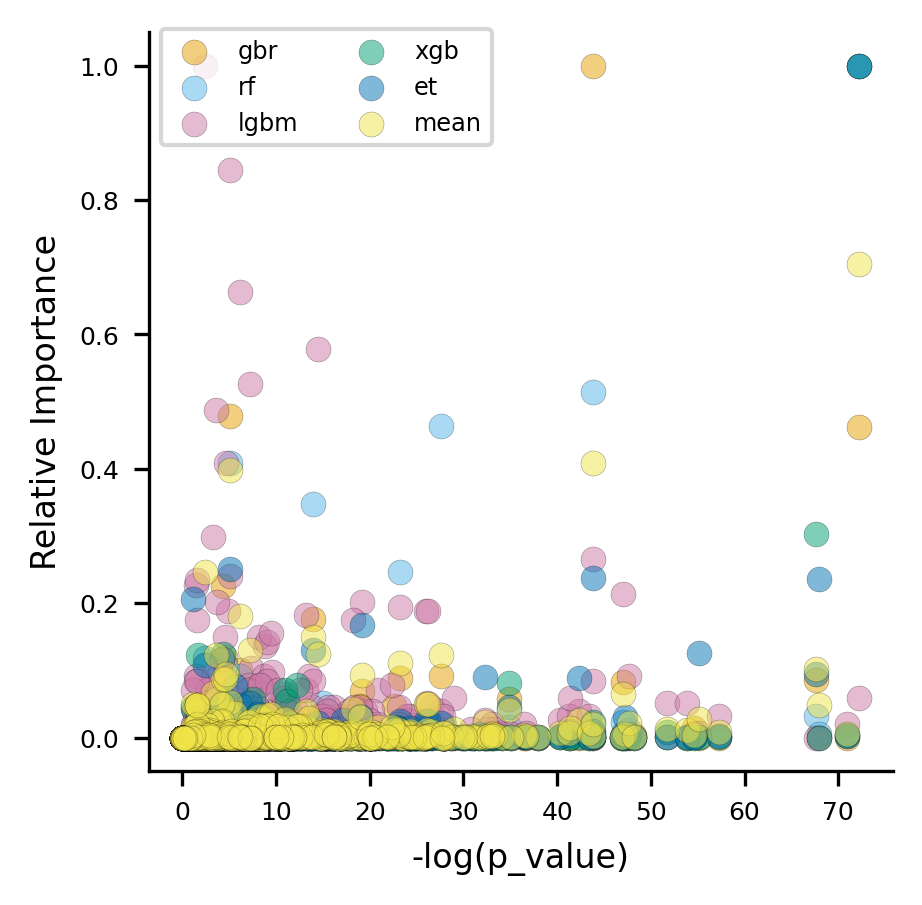

In [31]:
scatter_plot = plot_scatter(summary_result=sr, report_dir=report_dir)

In [32]:
%%time
mean_imp = mean_importance(top, report_dir=report_dir)

CPU times: total: 219 ms
Wall time: 221 ms


In [33]:
mean_imp.head()

feature       gbr        rf      lgbm       xgb        et      mean
0    1_H1  0.000000  0.001041  0.045455  0.000527  0.001183  0.009641
1    1_H3  0.000354  0.000298  0.006494  0.000000  0.000147  0.001458
2   1_NCI  0.000000  0.000270  0.006494  0.000327  0.000131  0.001444
3    2_H1  0.000000  0.000159  0.012987  0.000710  0.000548  0.002881
4    2_H3  0.000000  0.000358  0.012987  0.000670  0.007218  0.004247

mean Done


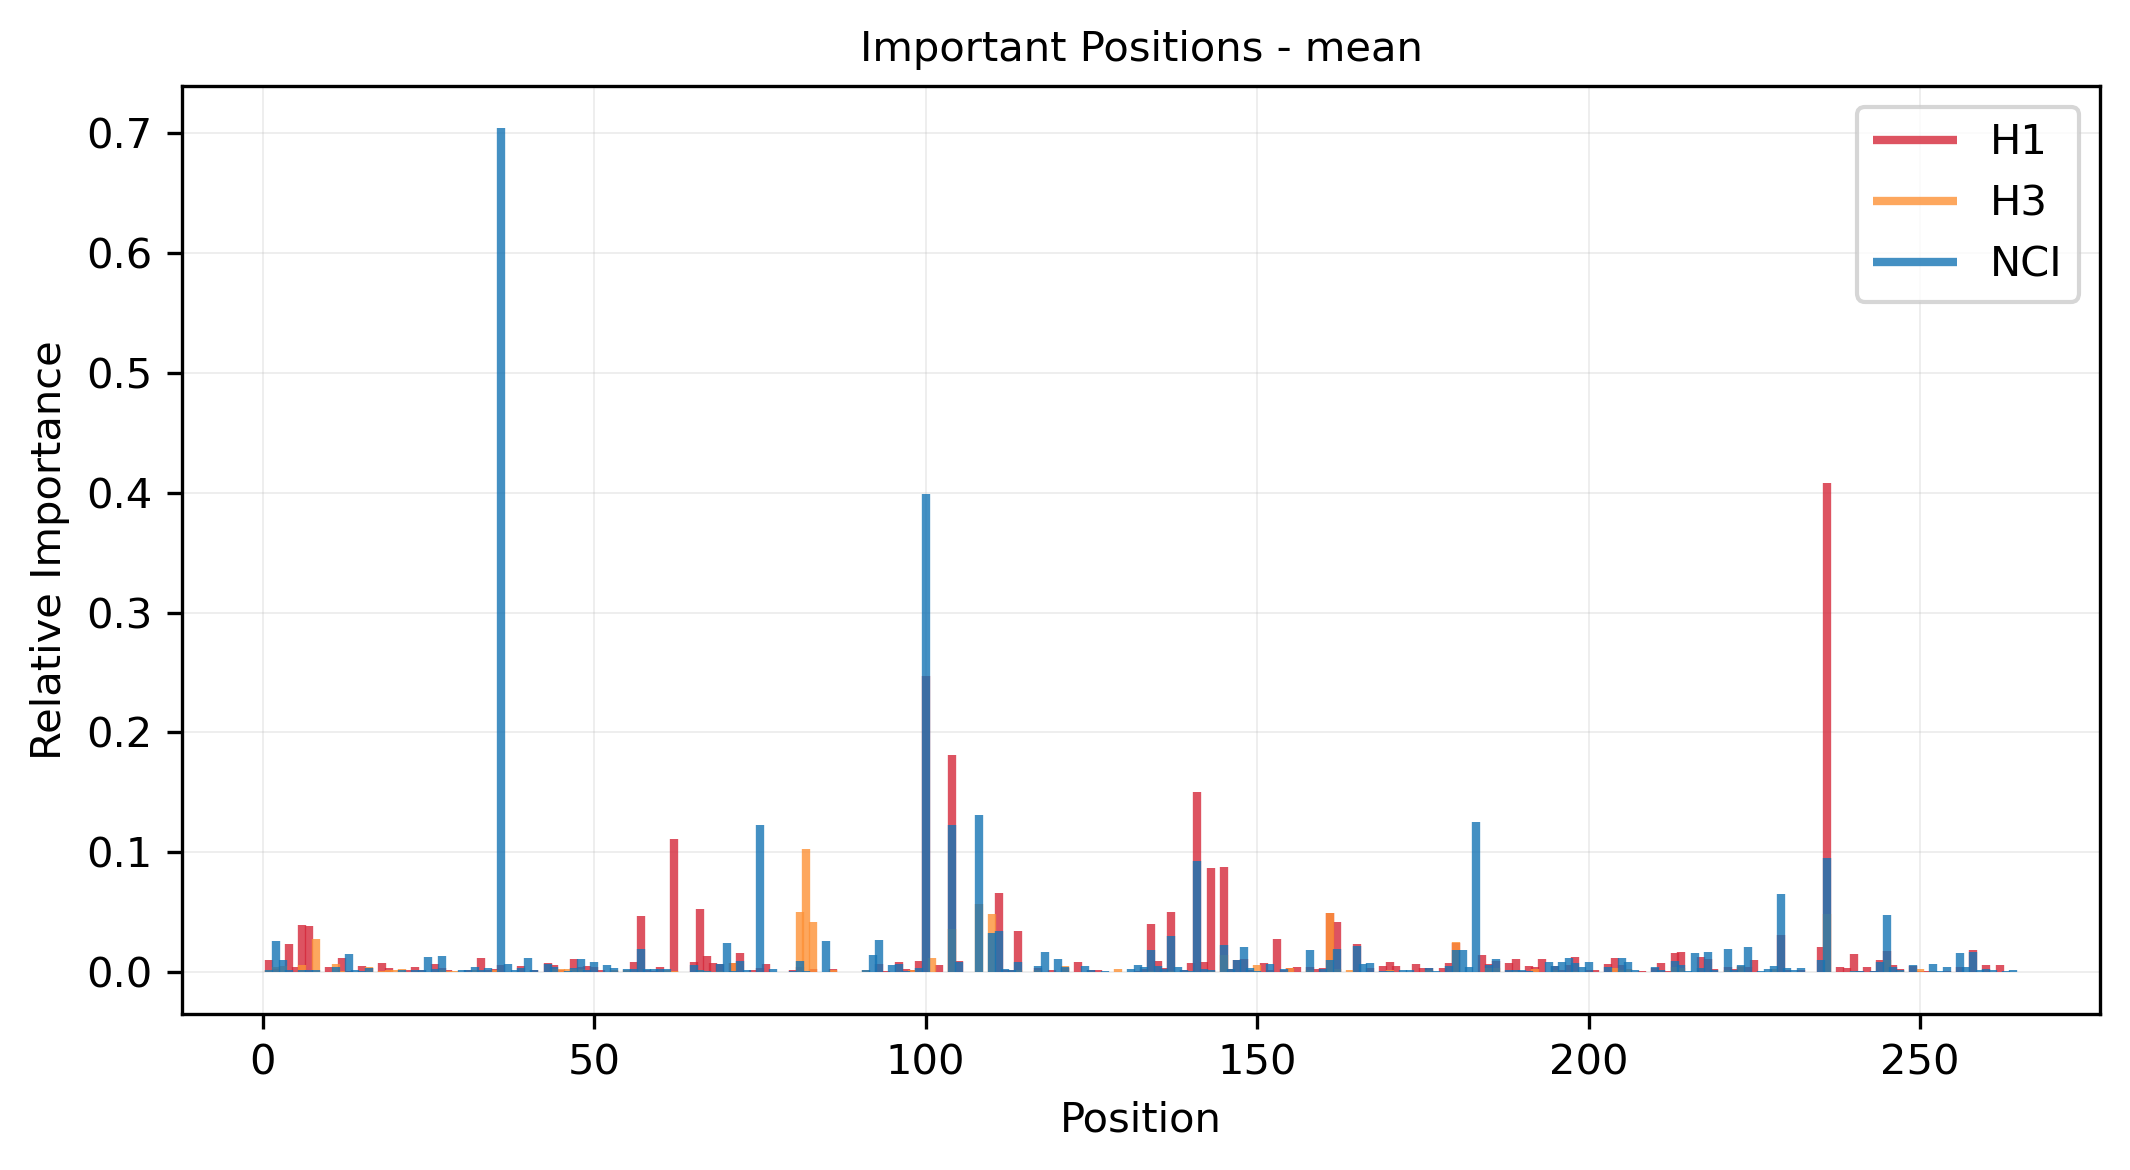

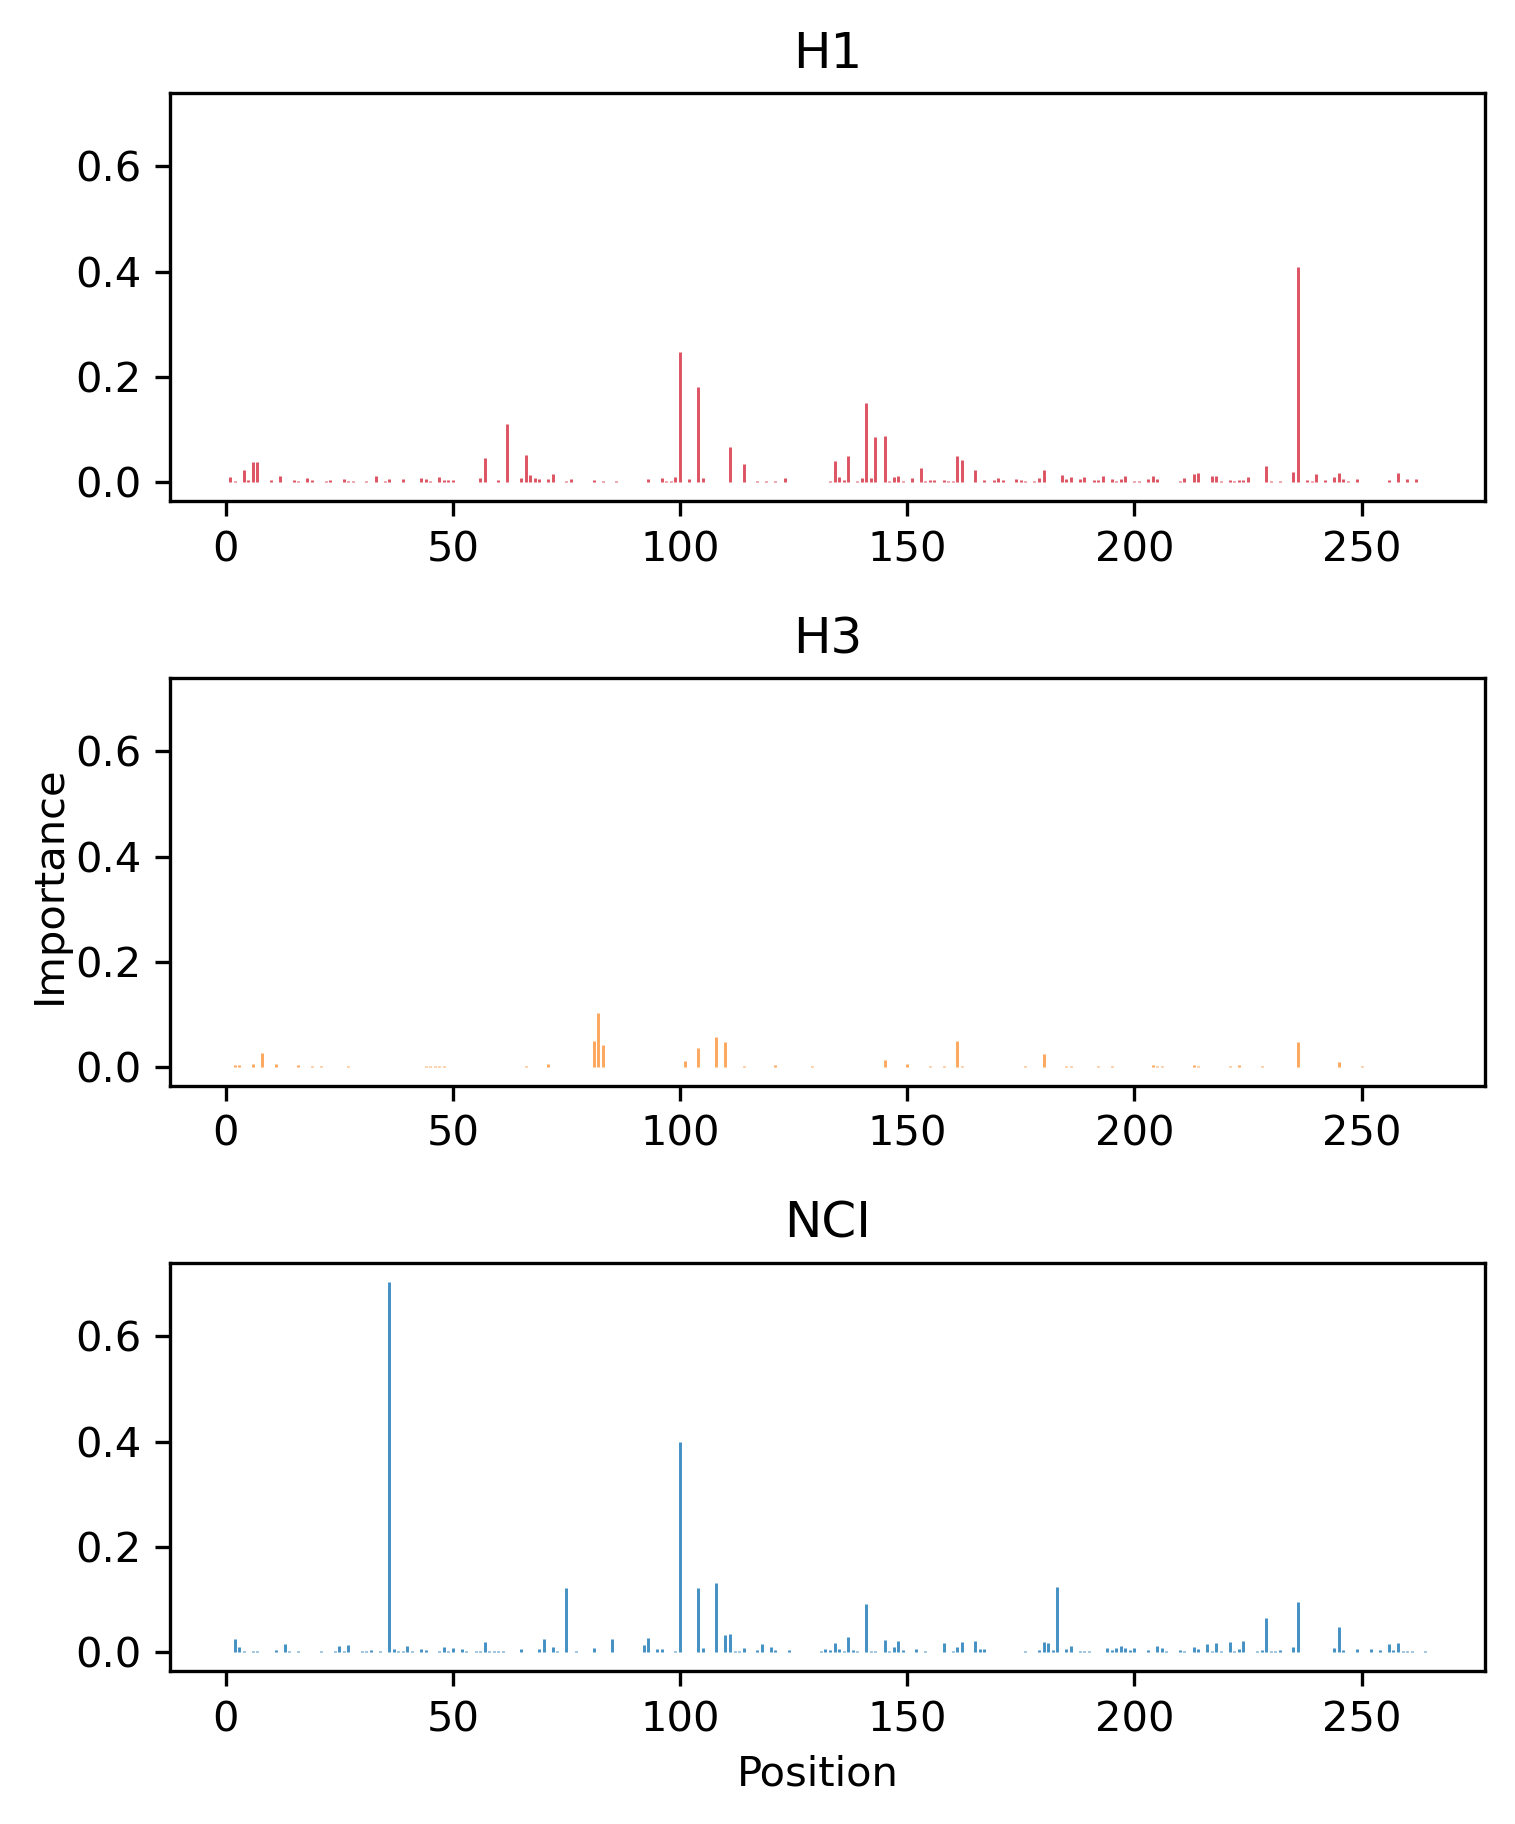

In [34]:
dp_aa_prop_plot(importance=mean_imp,imp_col='mean', model_name='mean', report_dir=report_dir, props_to_keep = props_to_keep)

gbr Done
gbr  Done
rf Done
rf  Done
lgbm Done
lgbm  Done
xgb Done
xgb  Done
et Done
et  Done


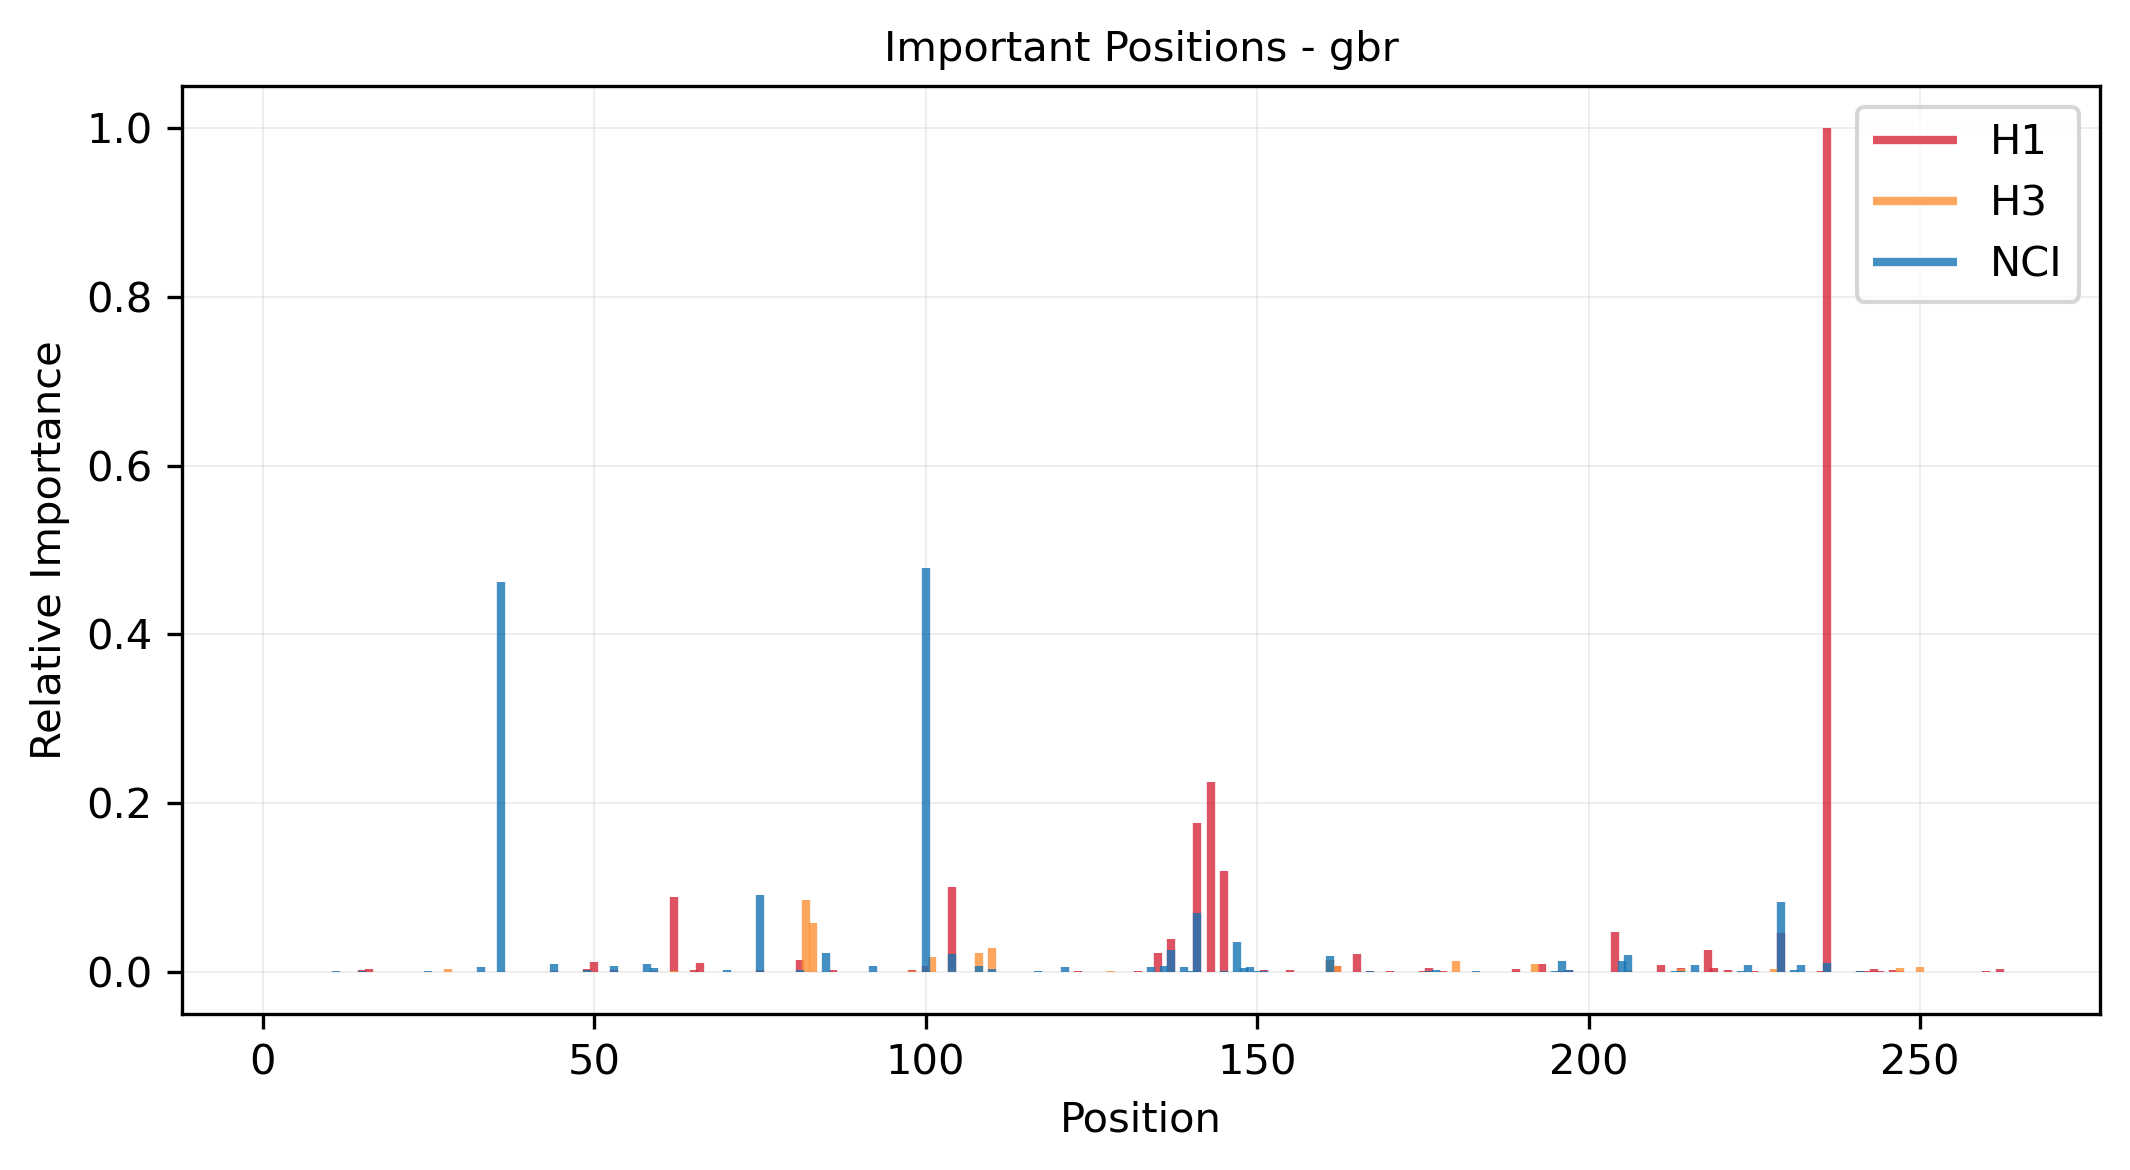

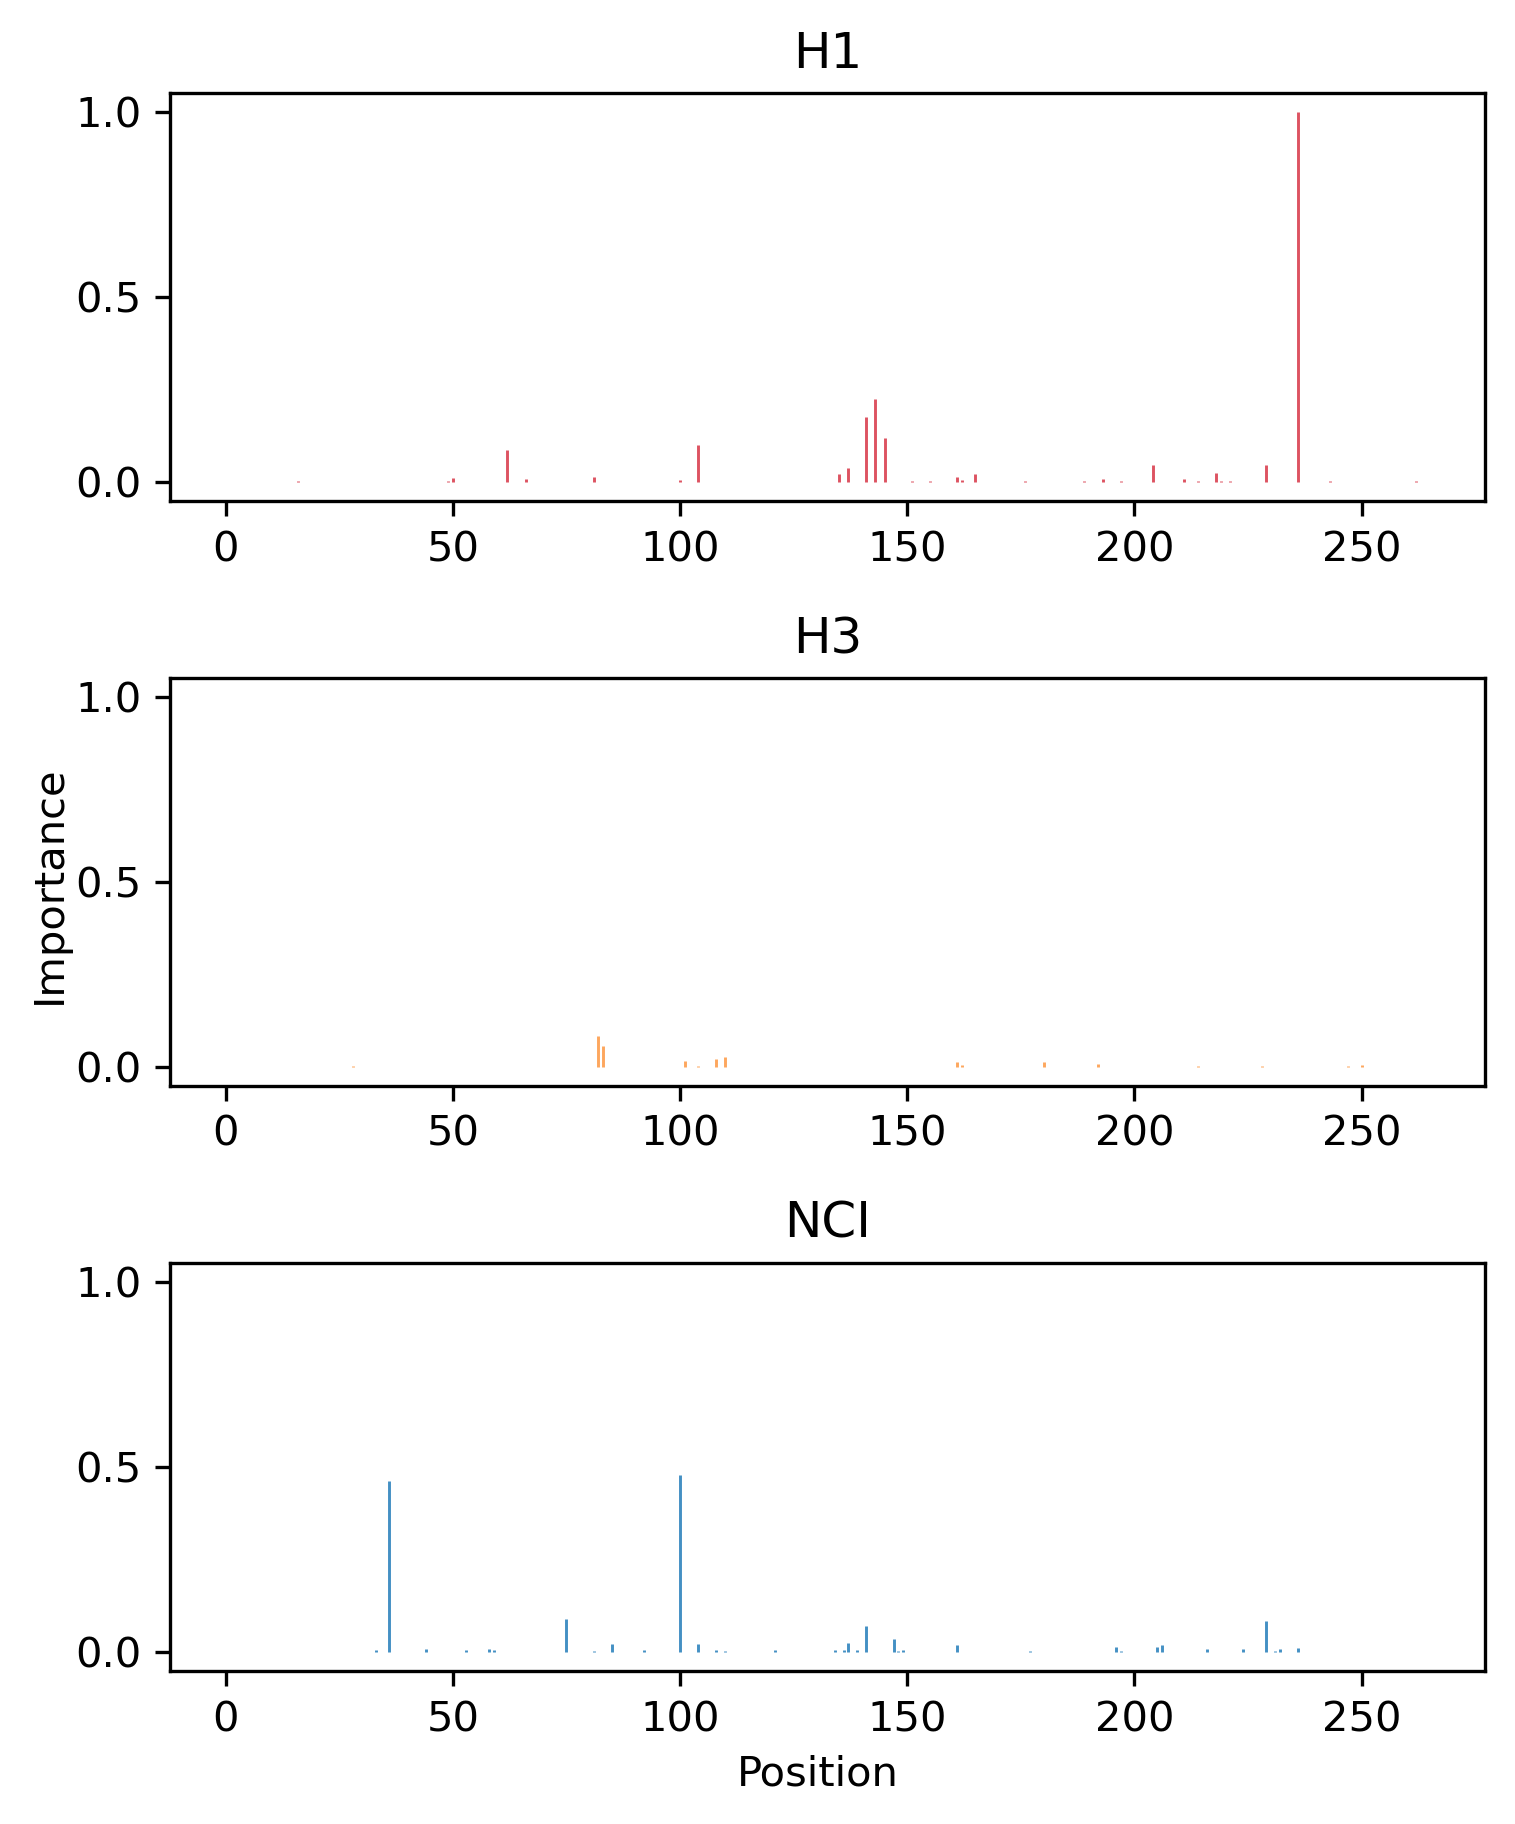

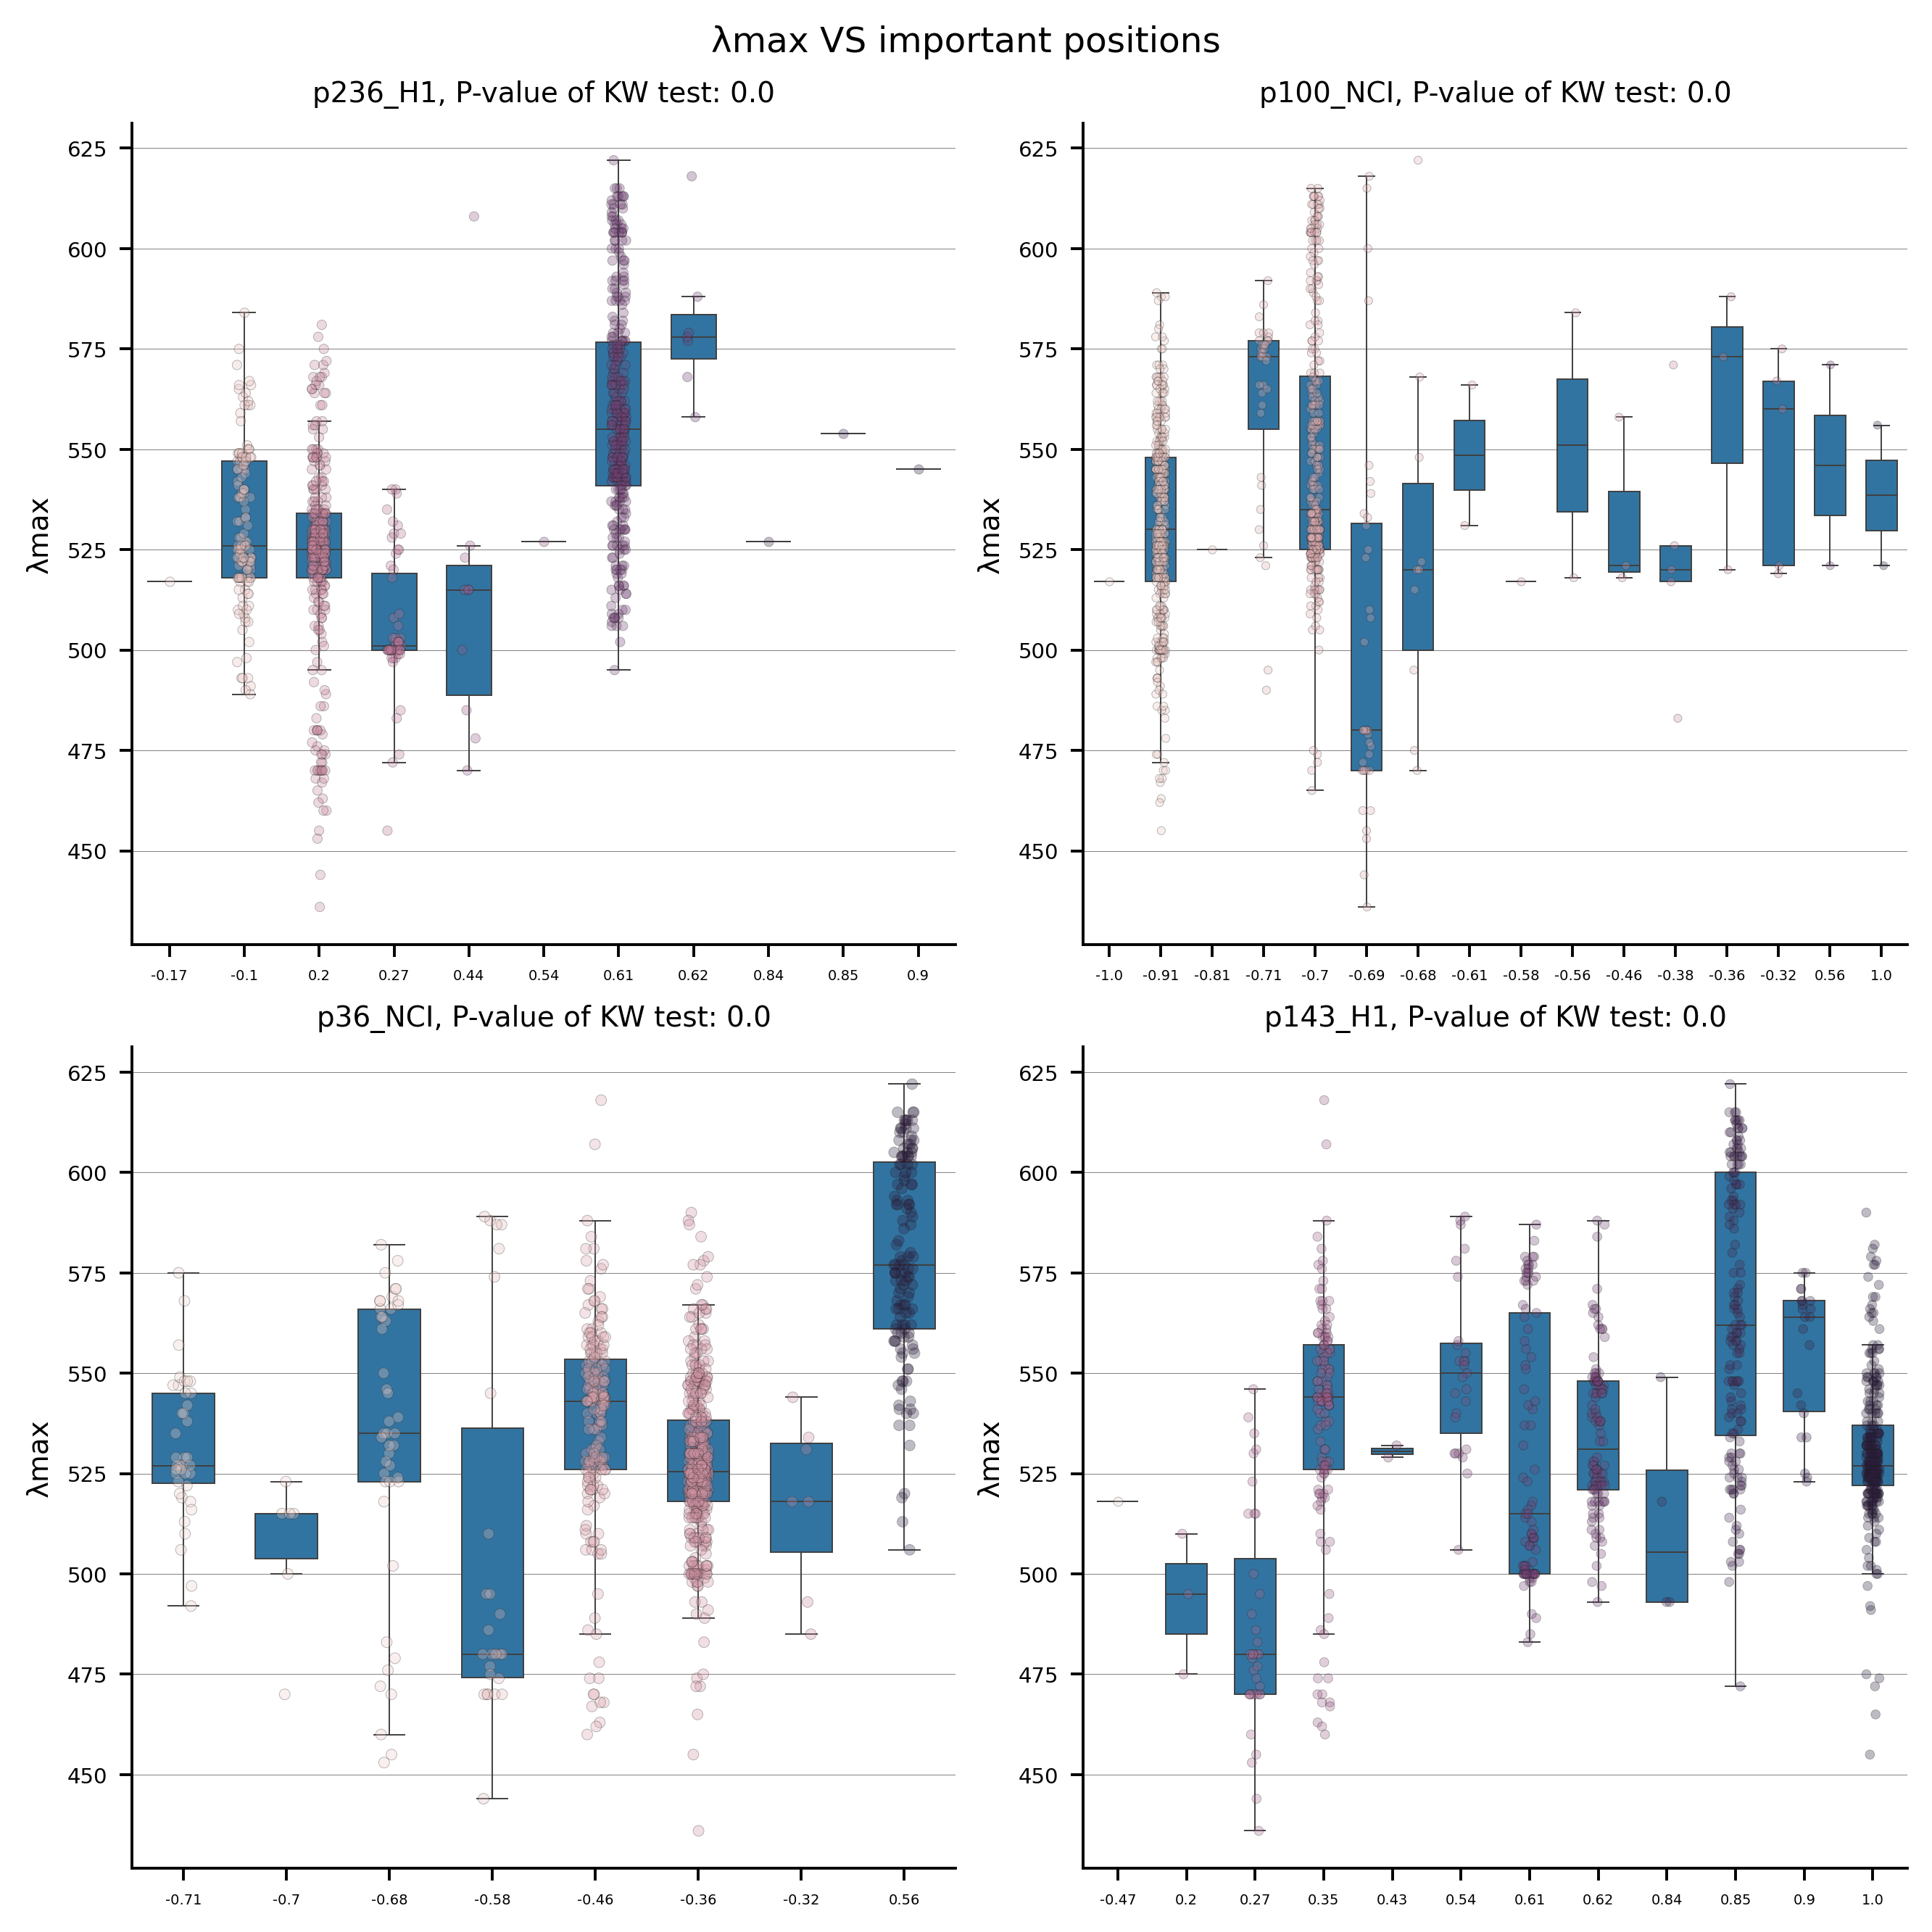

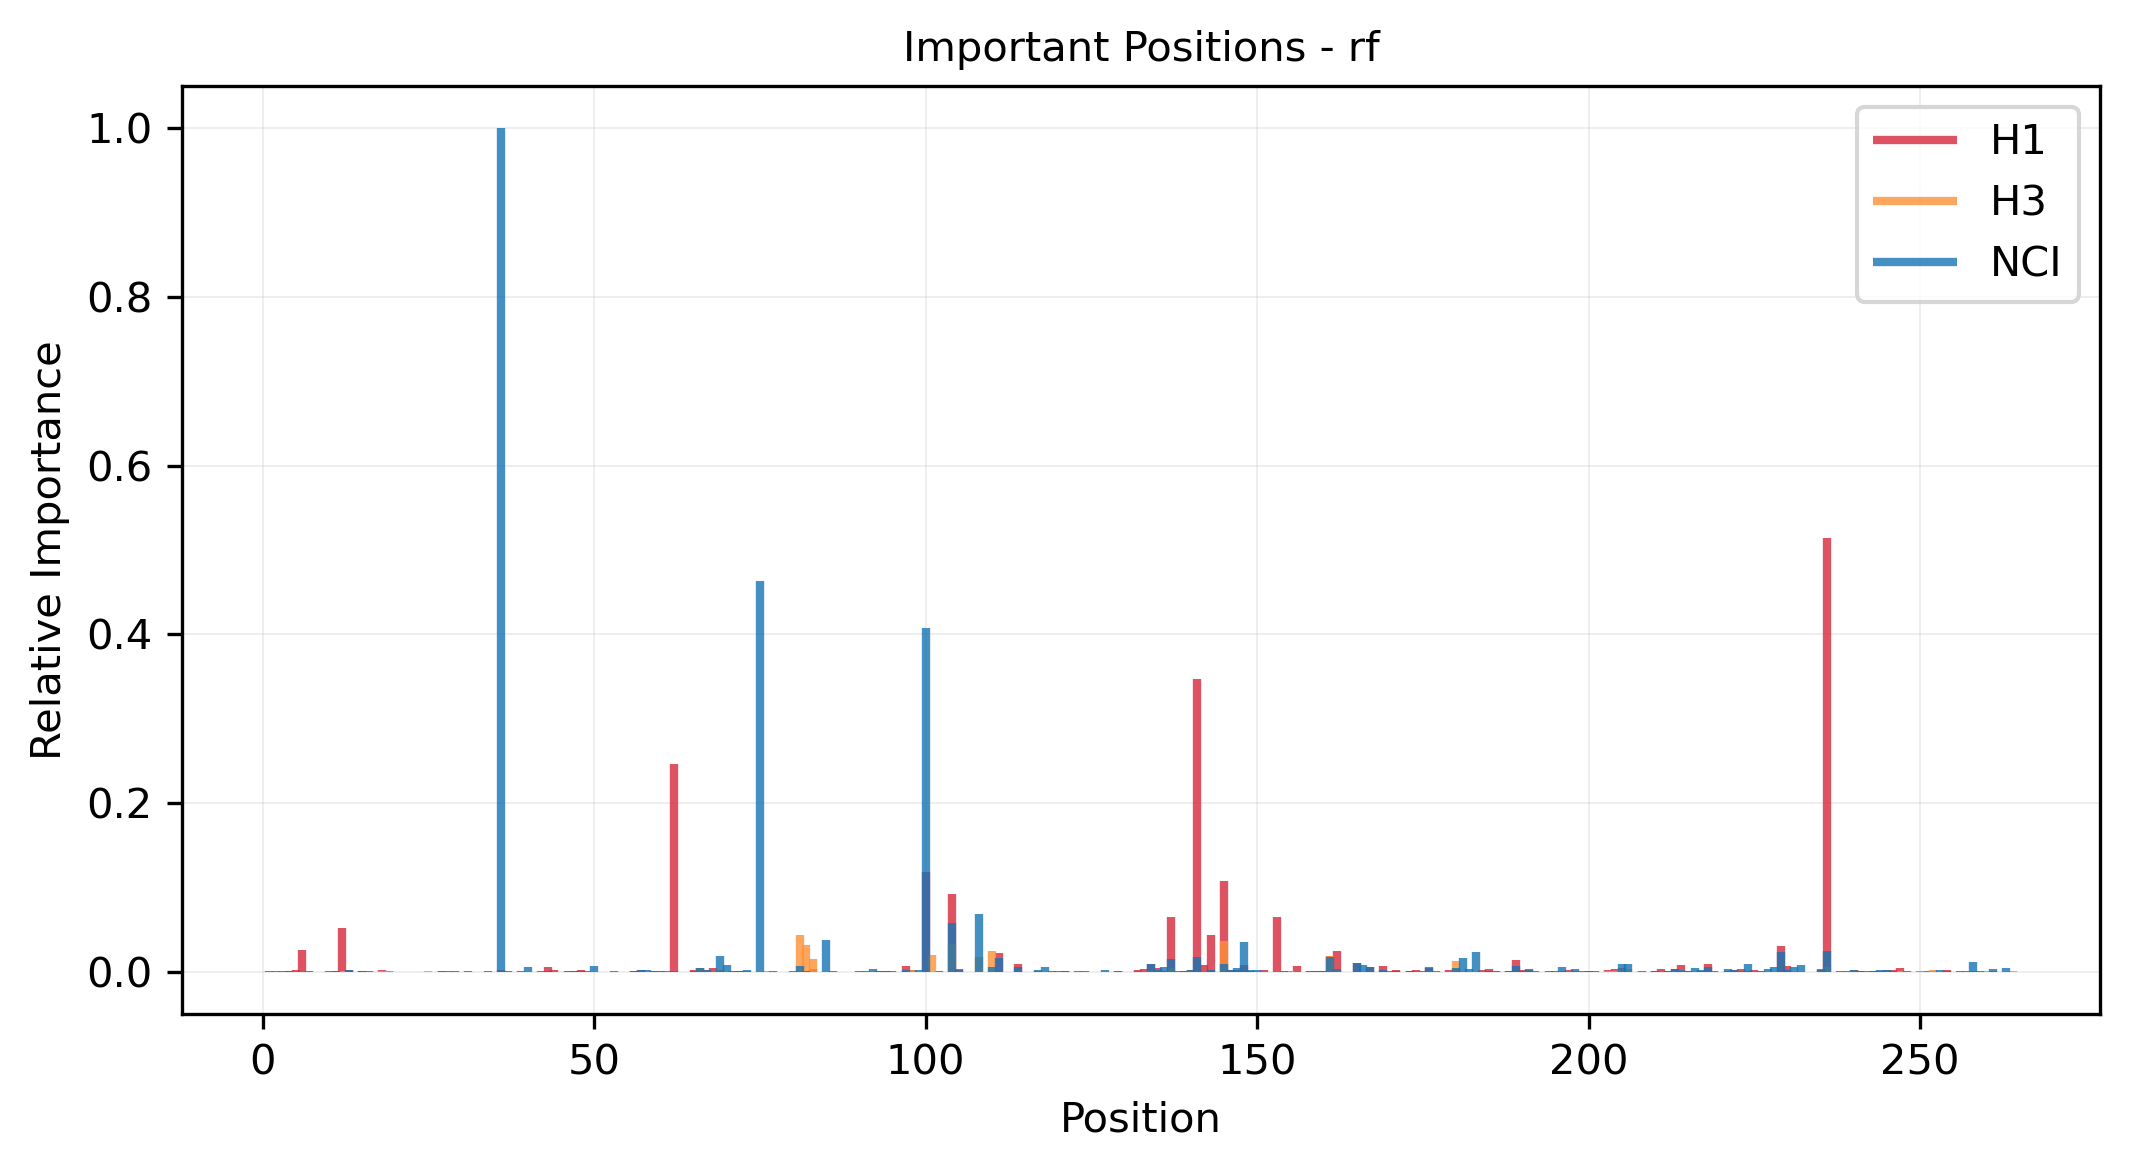

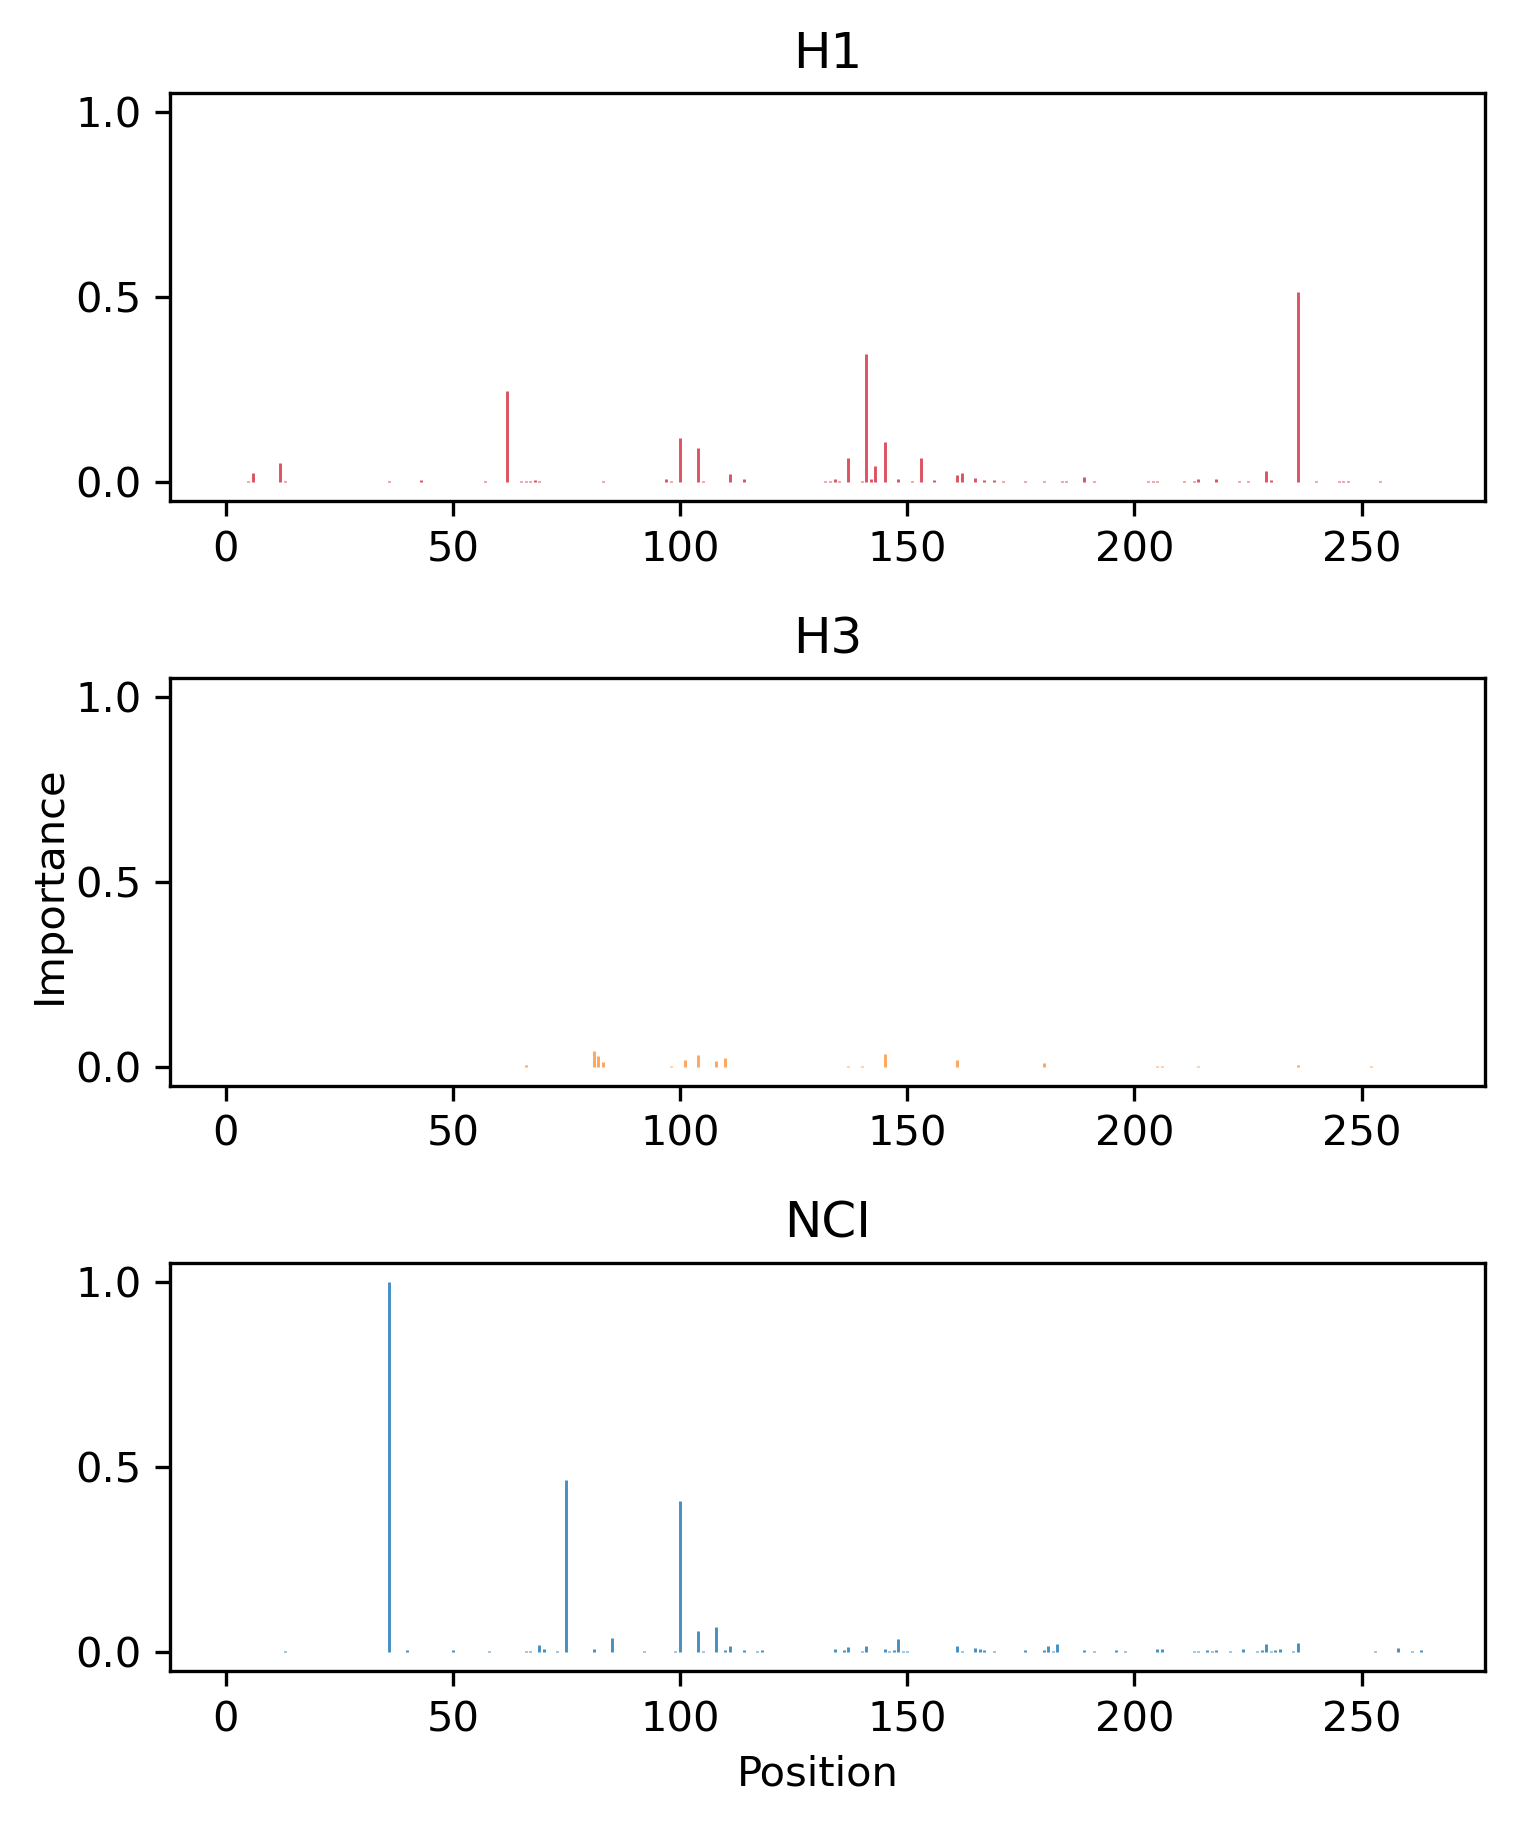

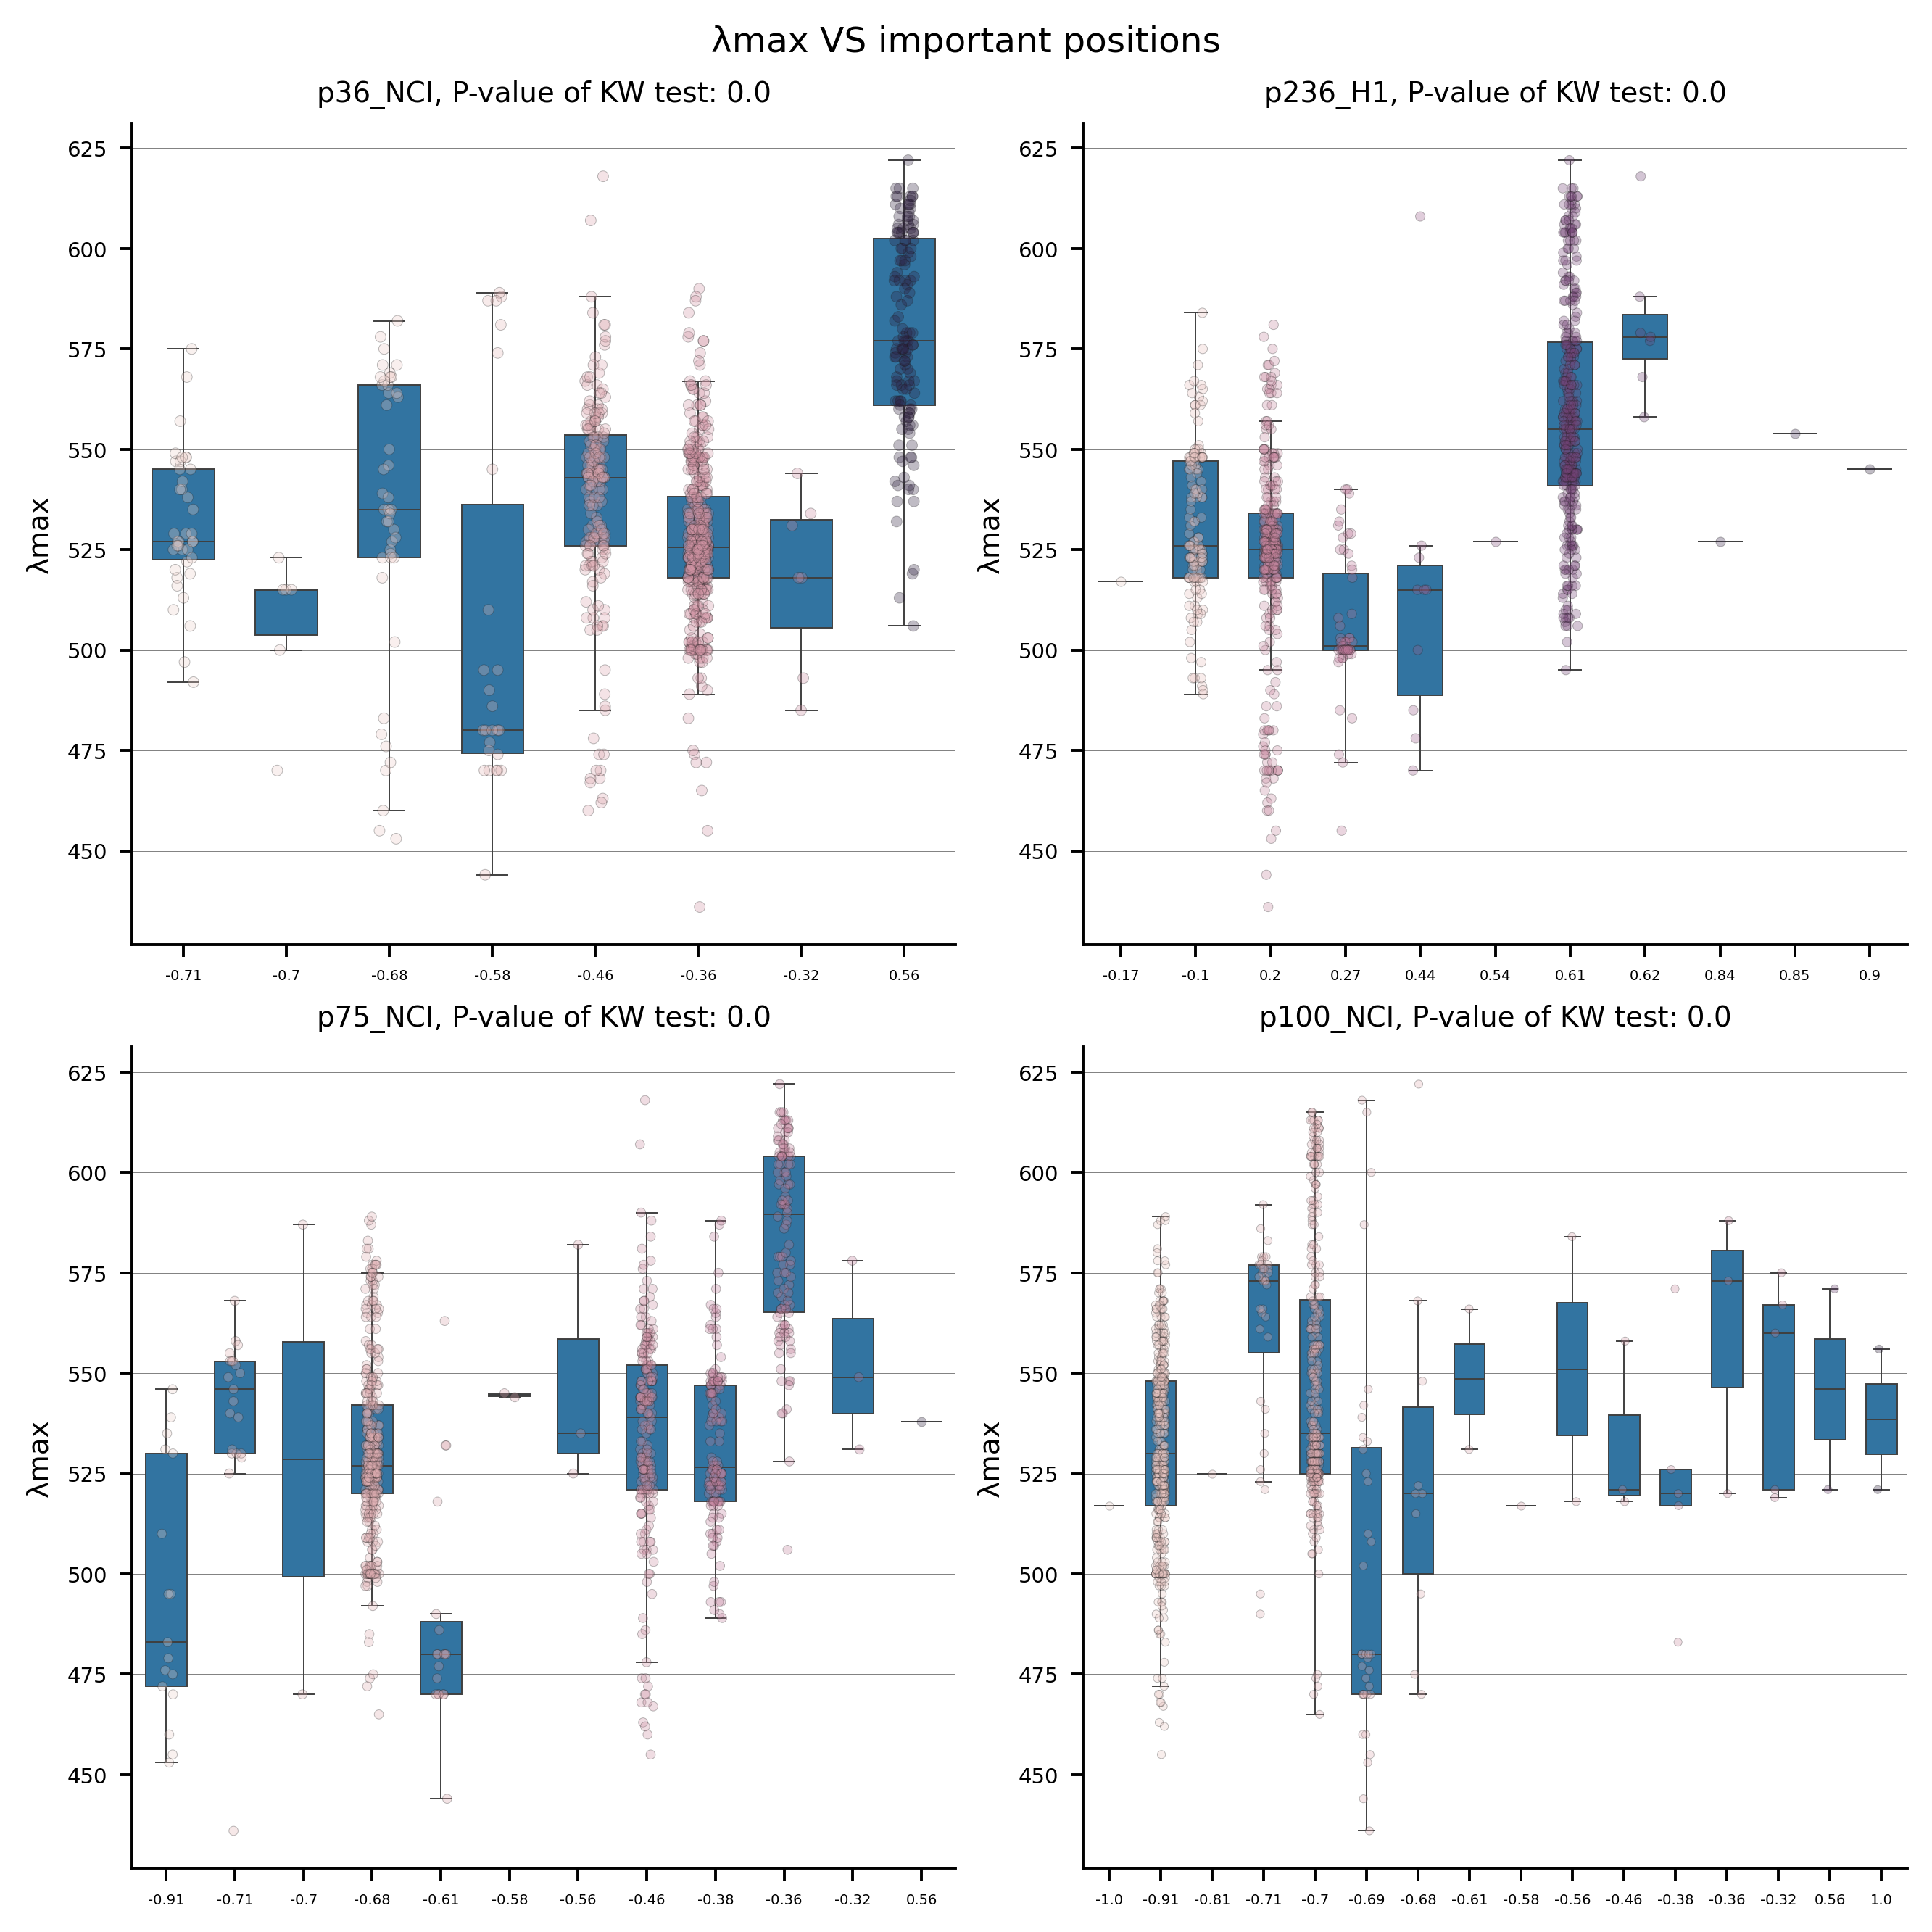

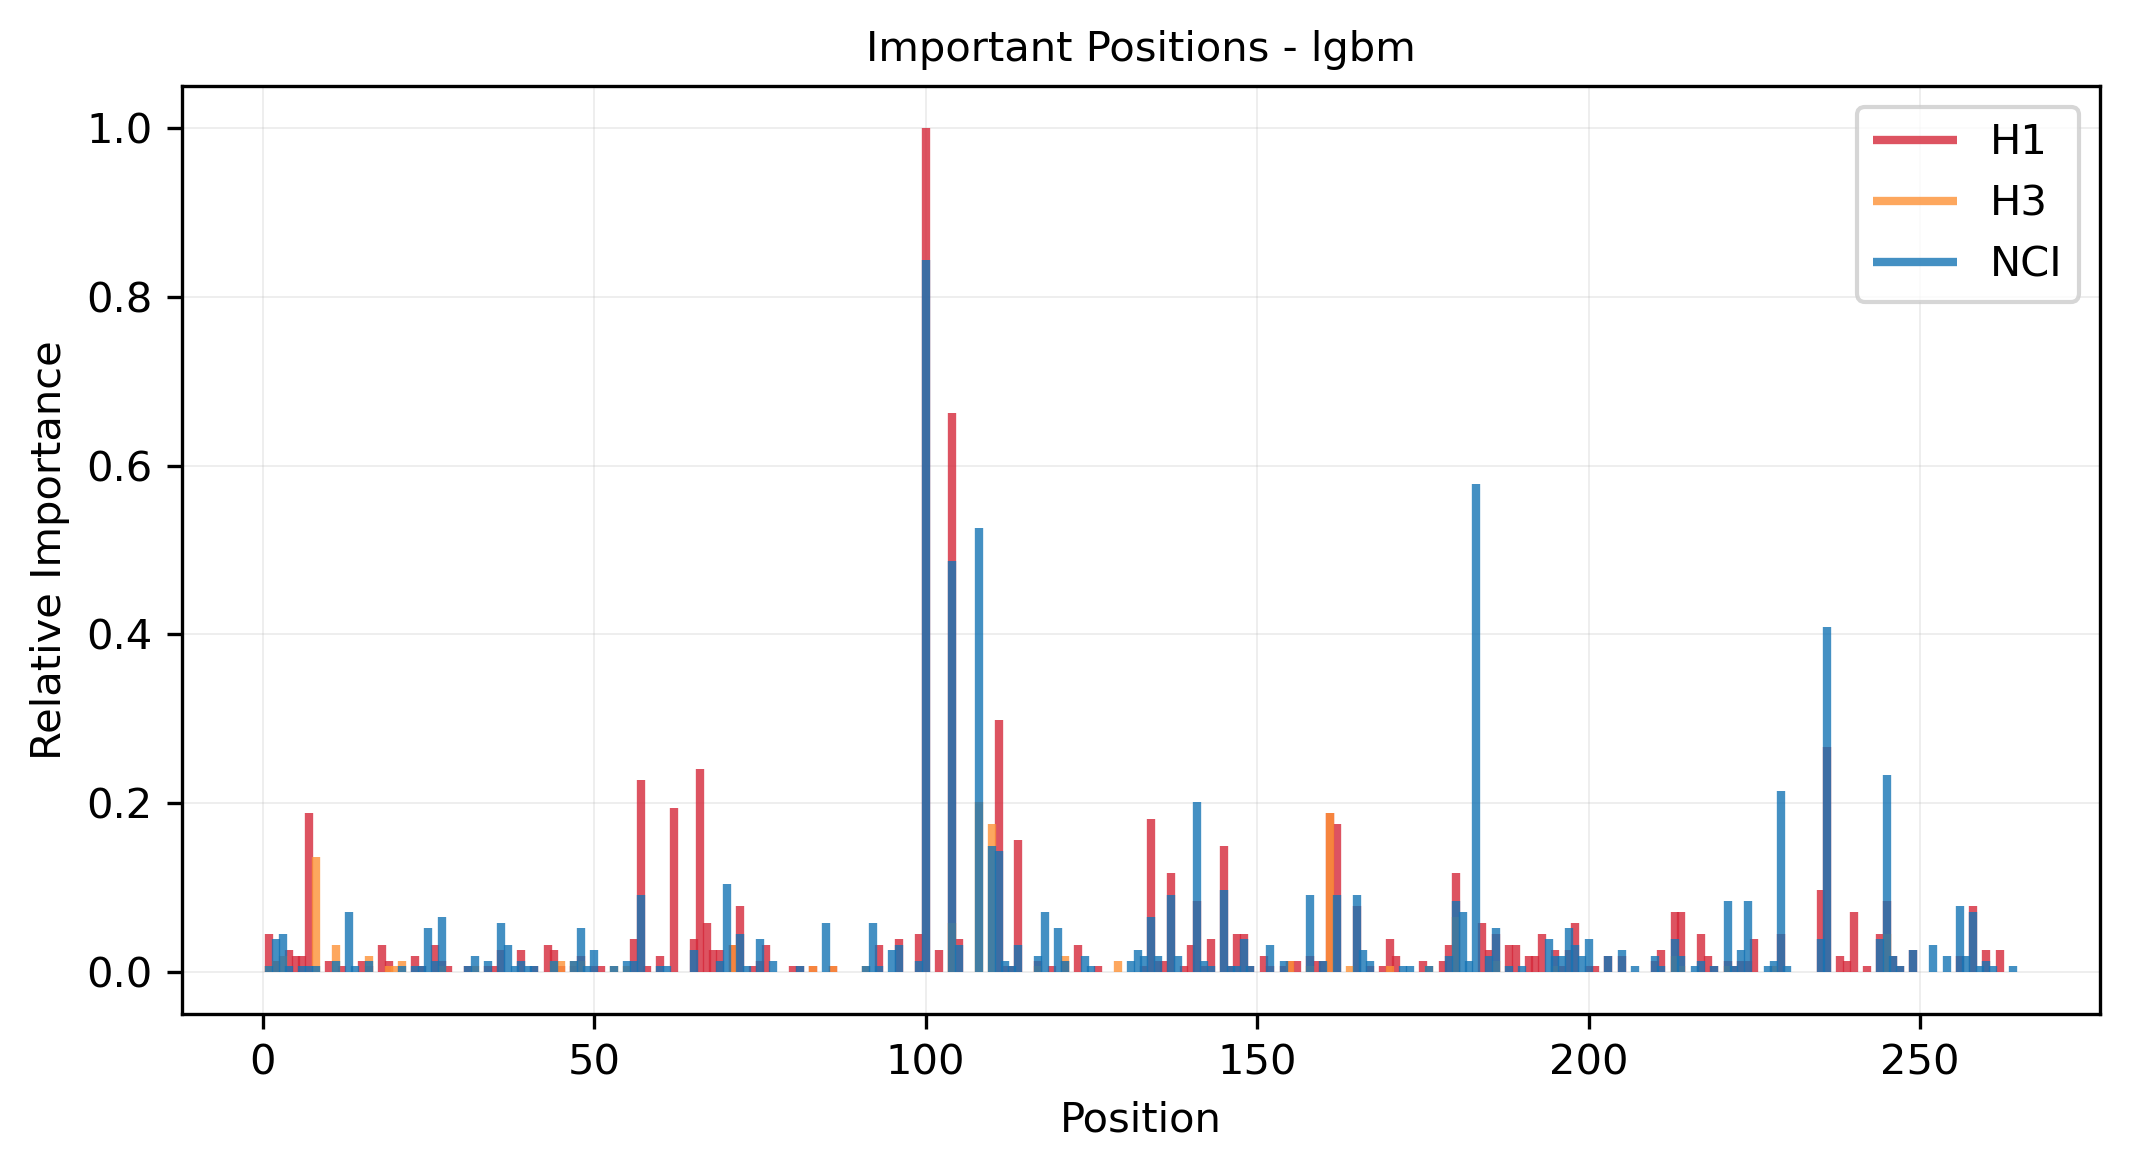

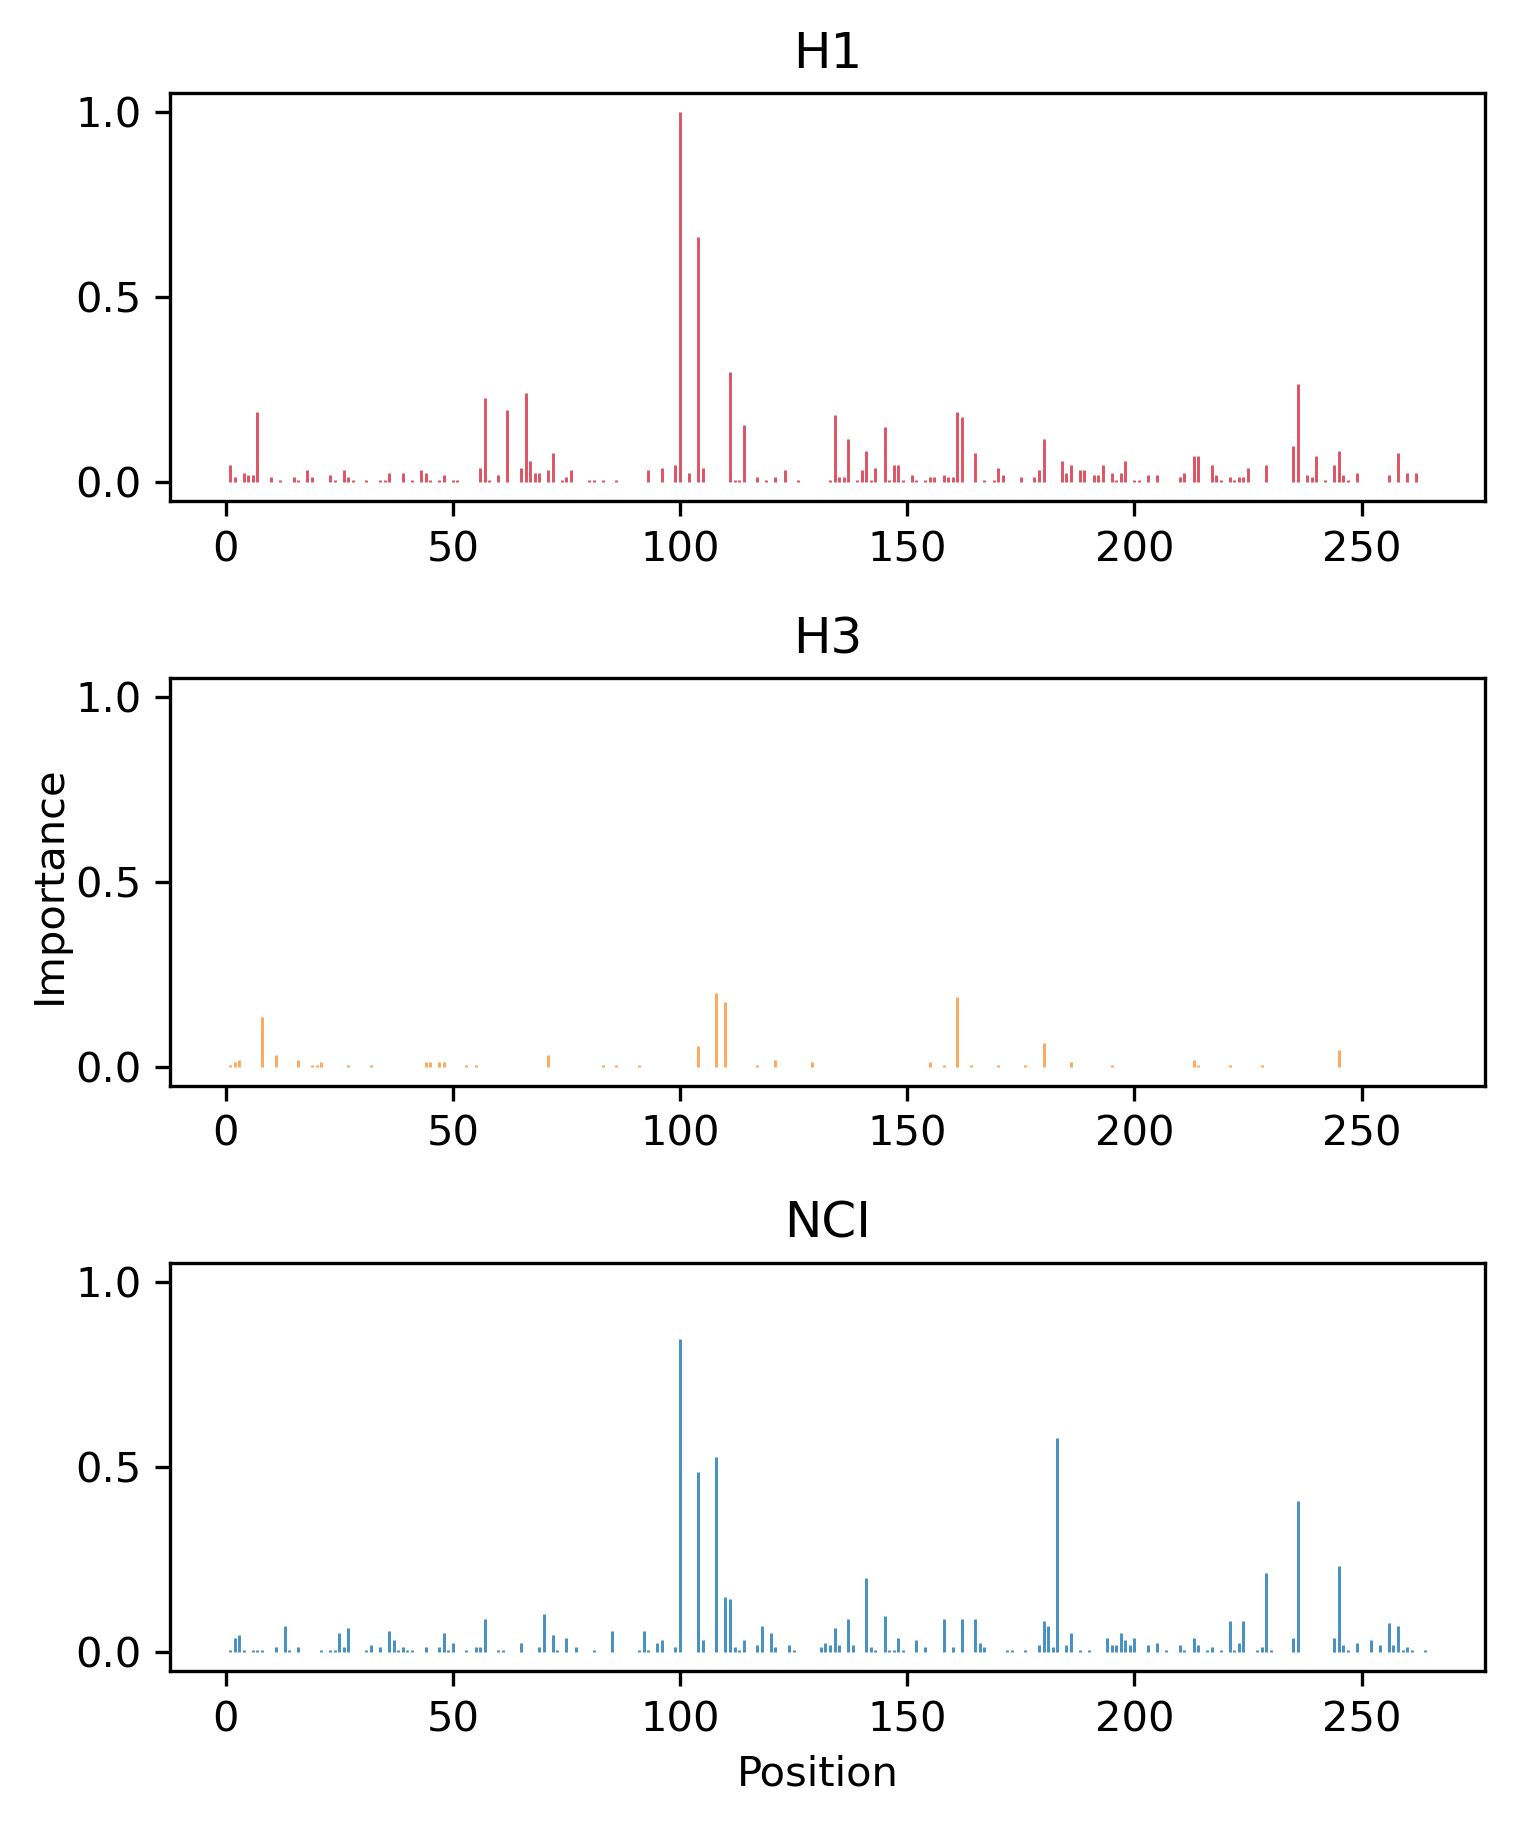

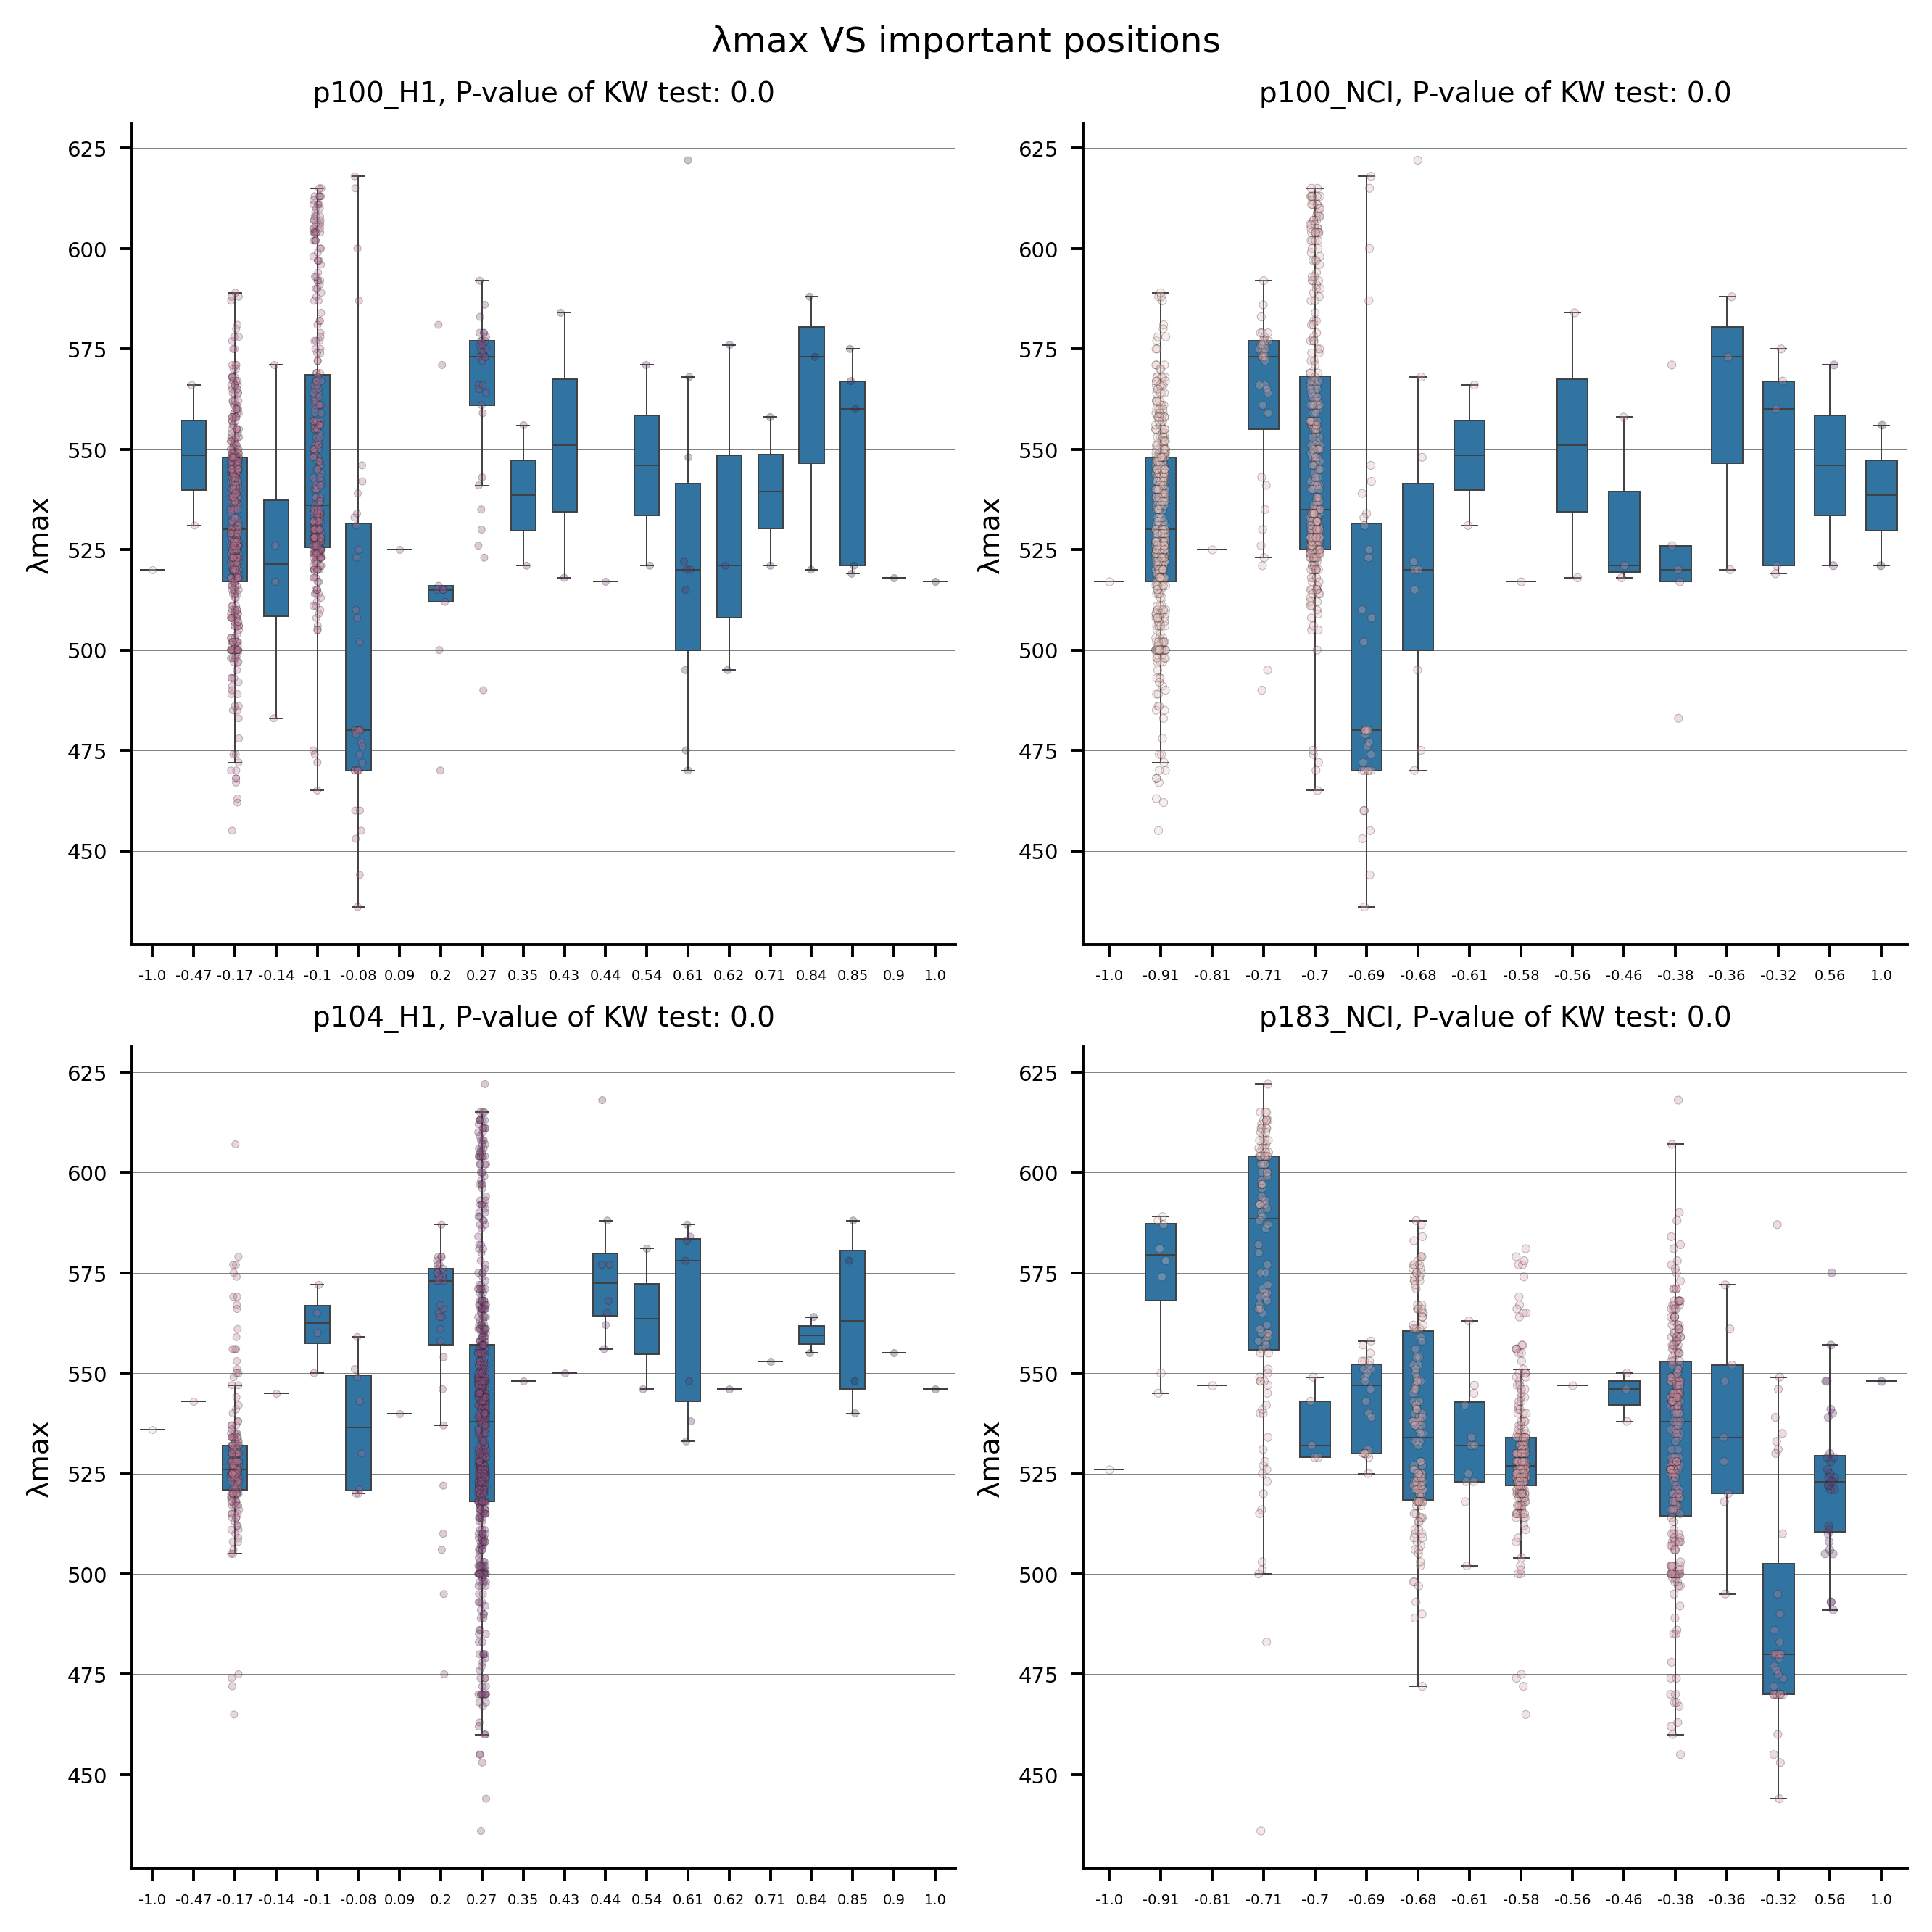

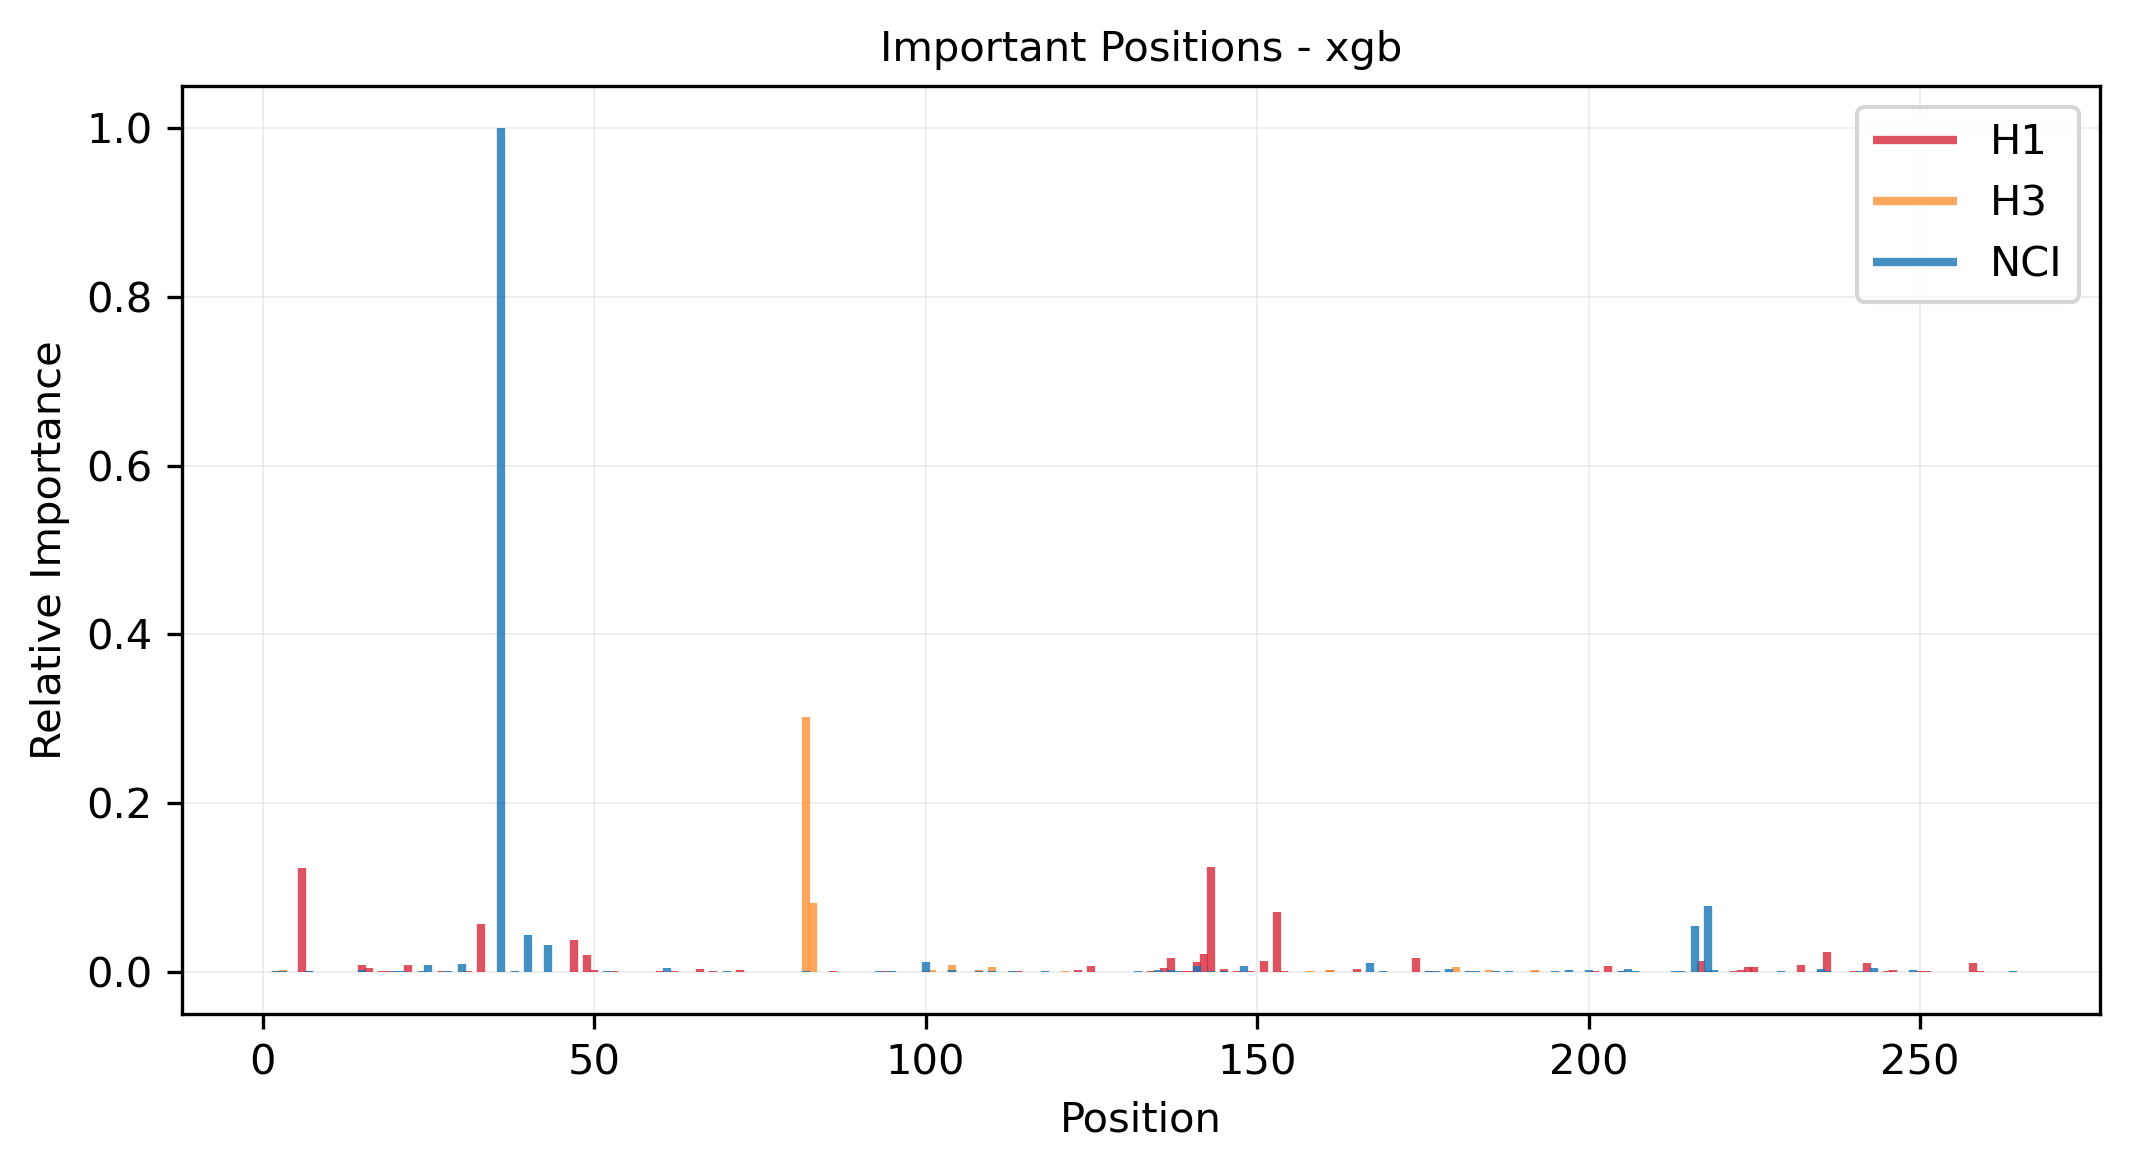

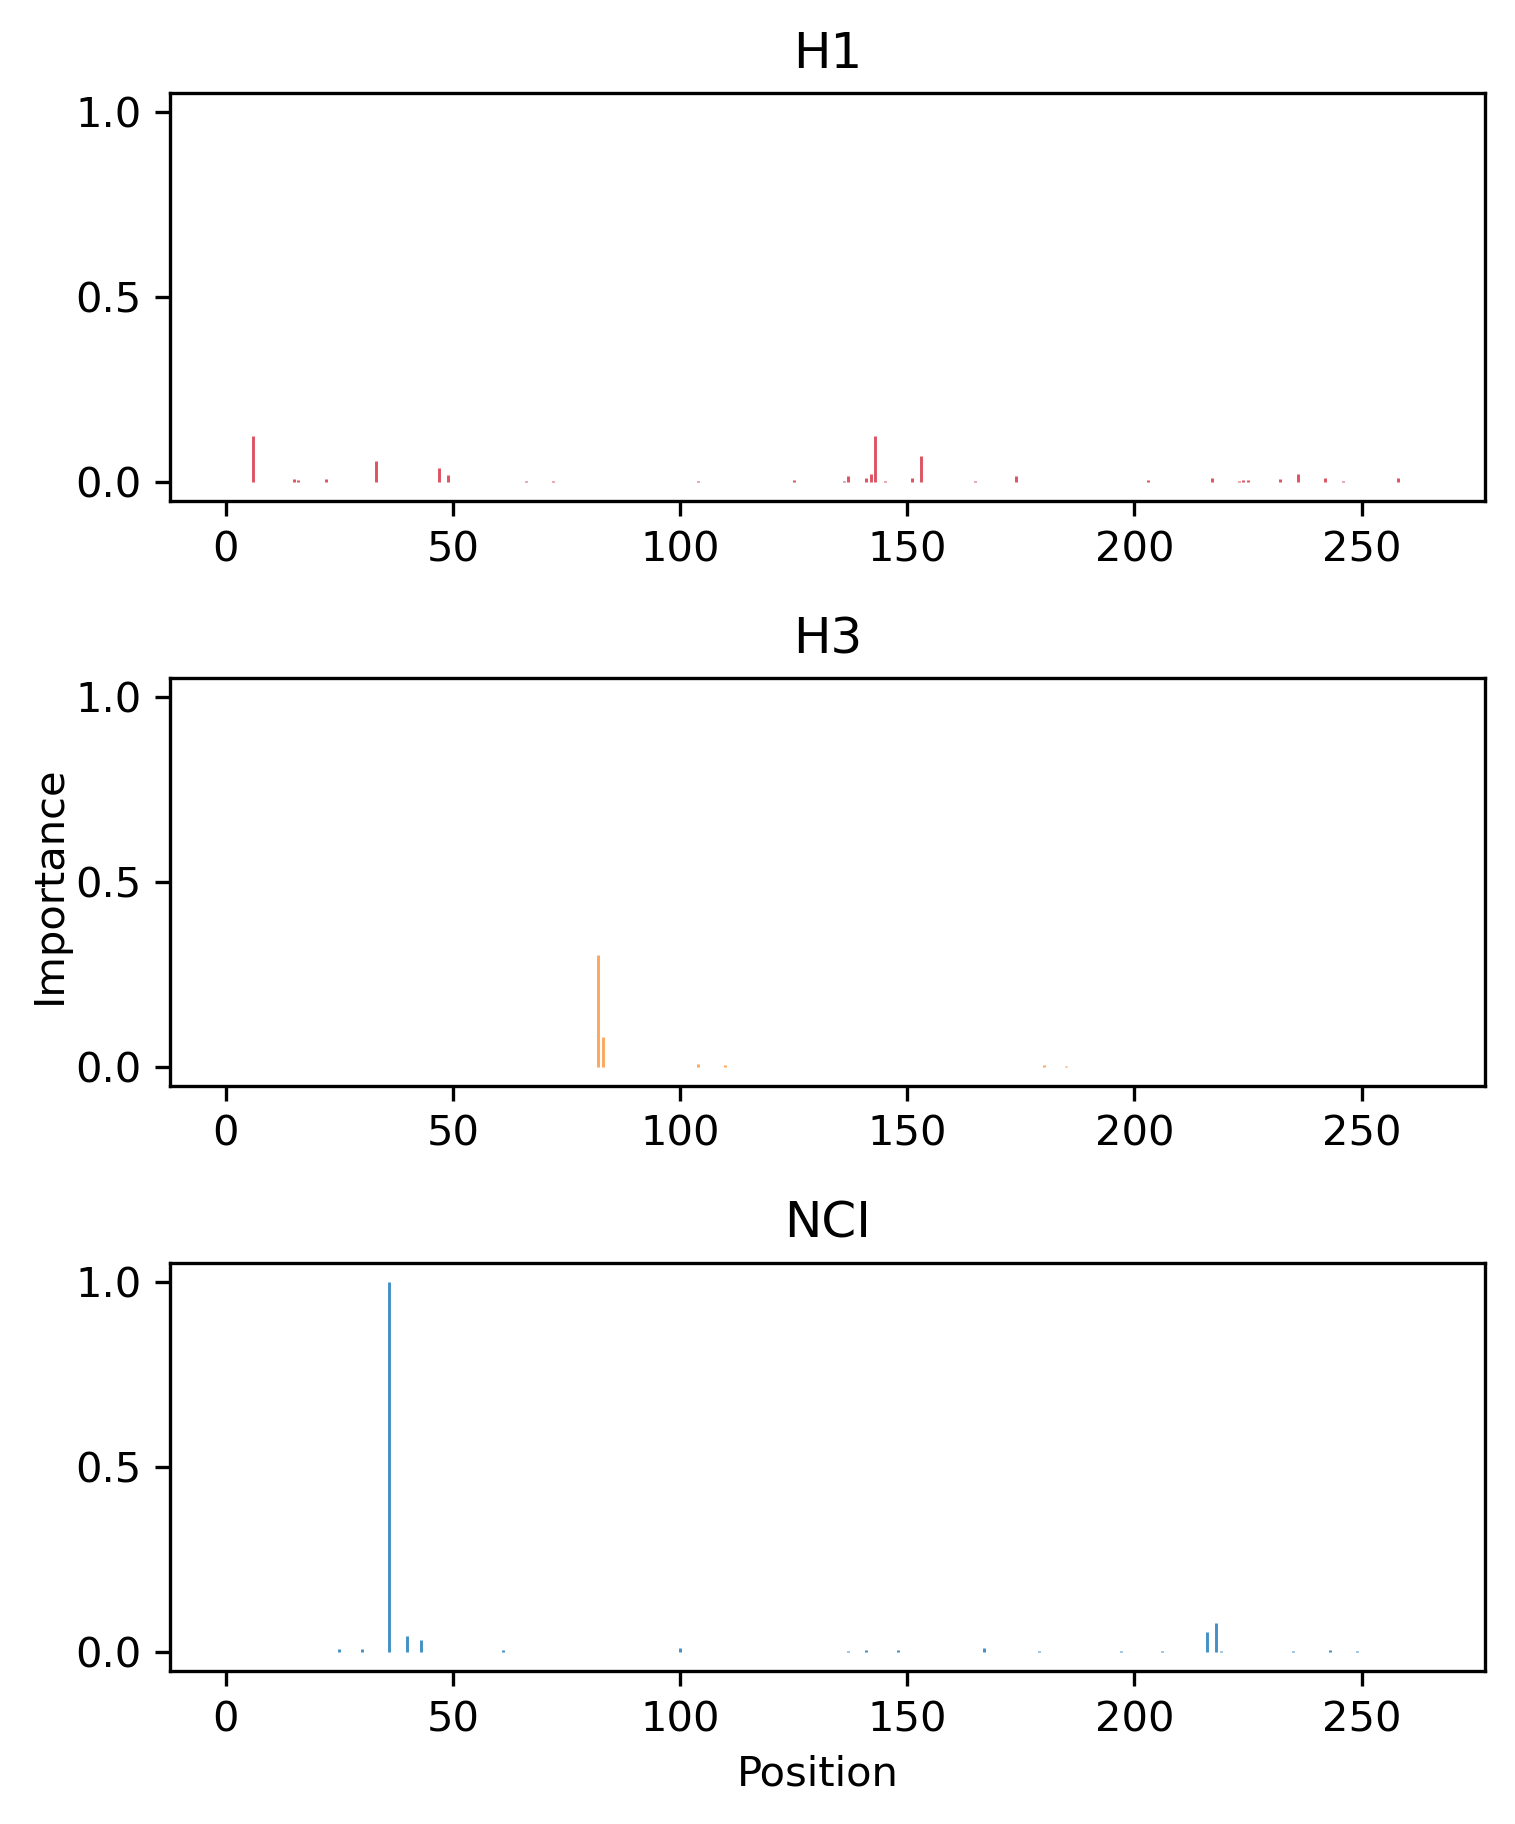

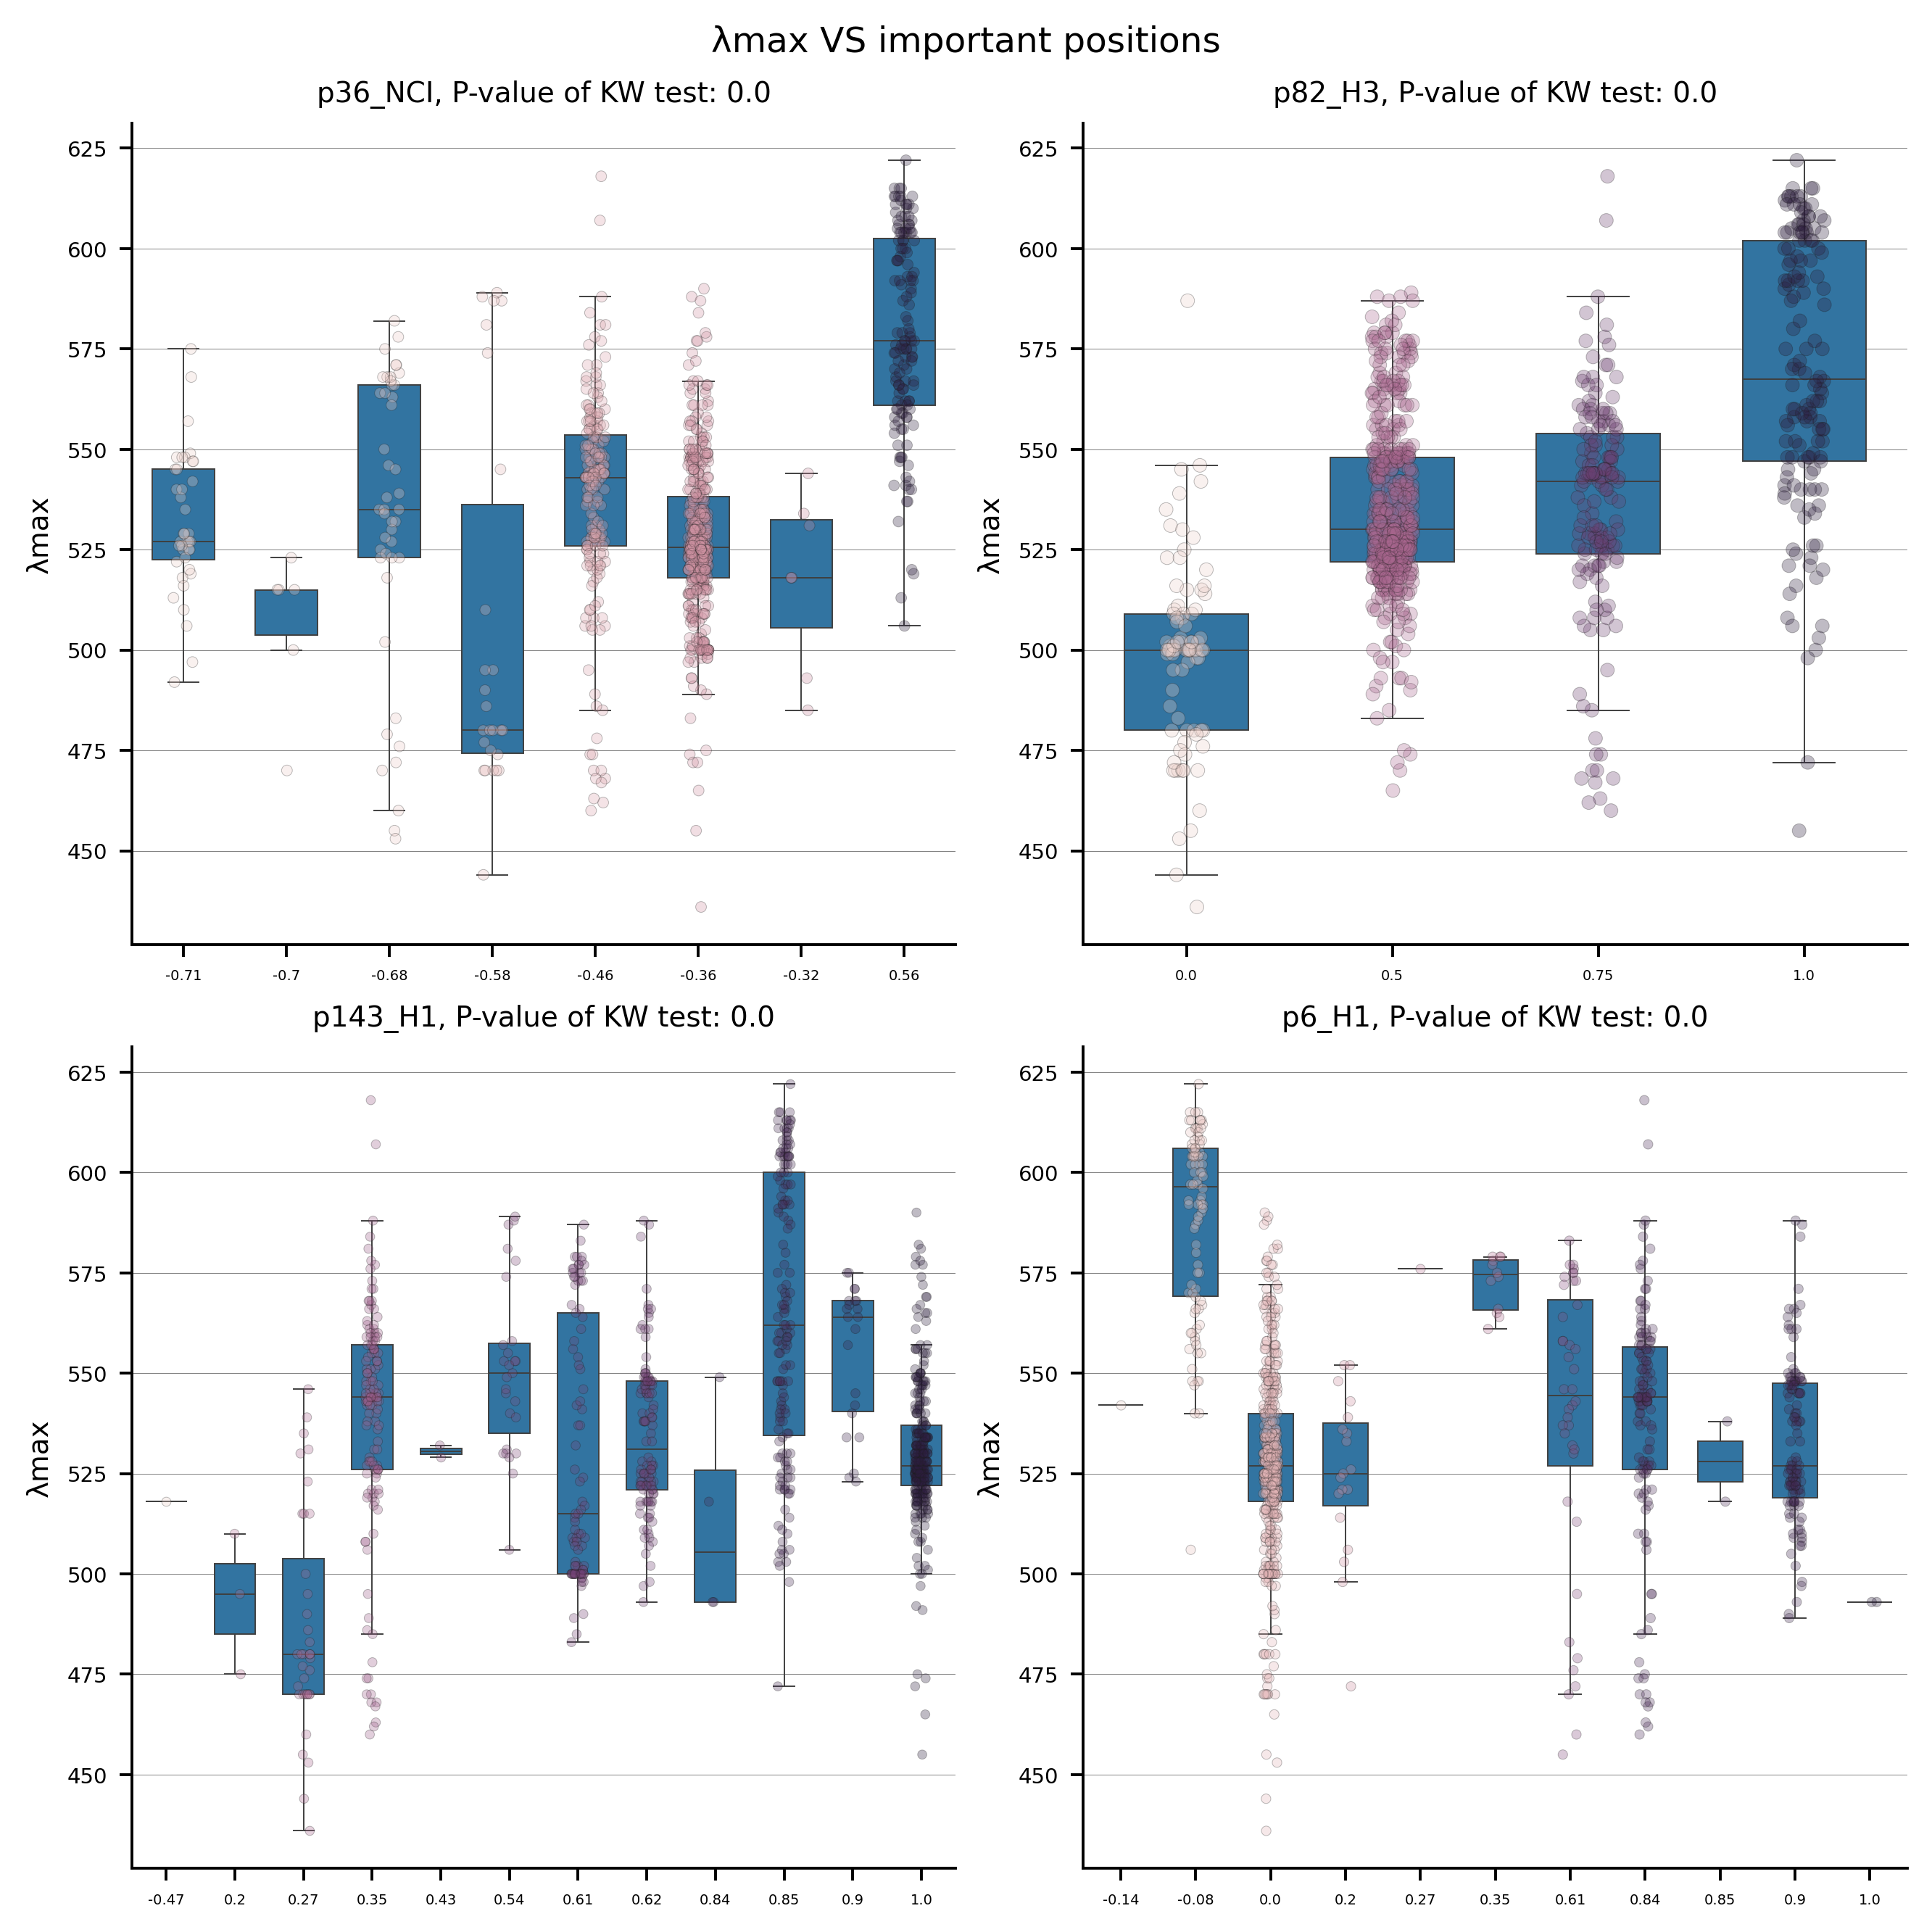

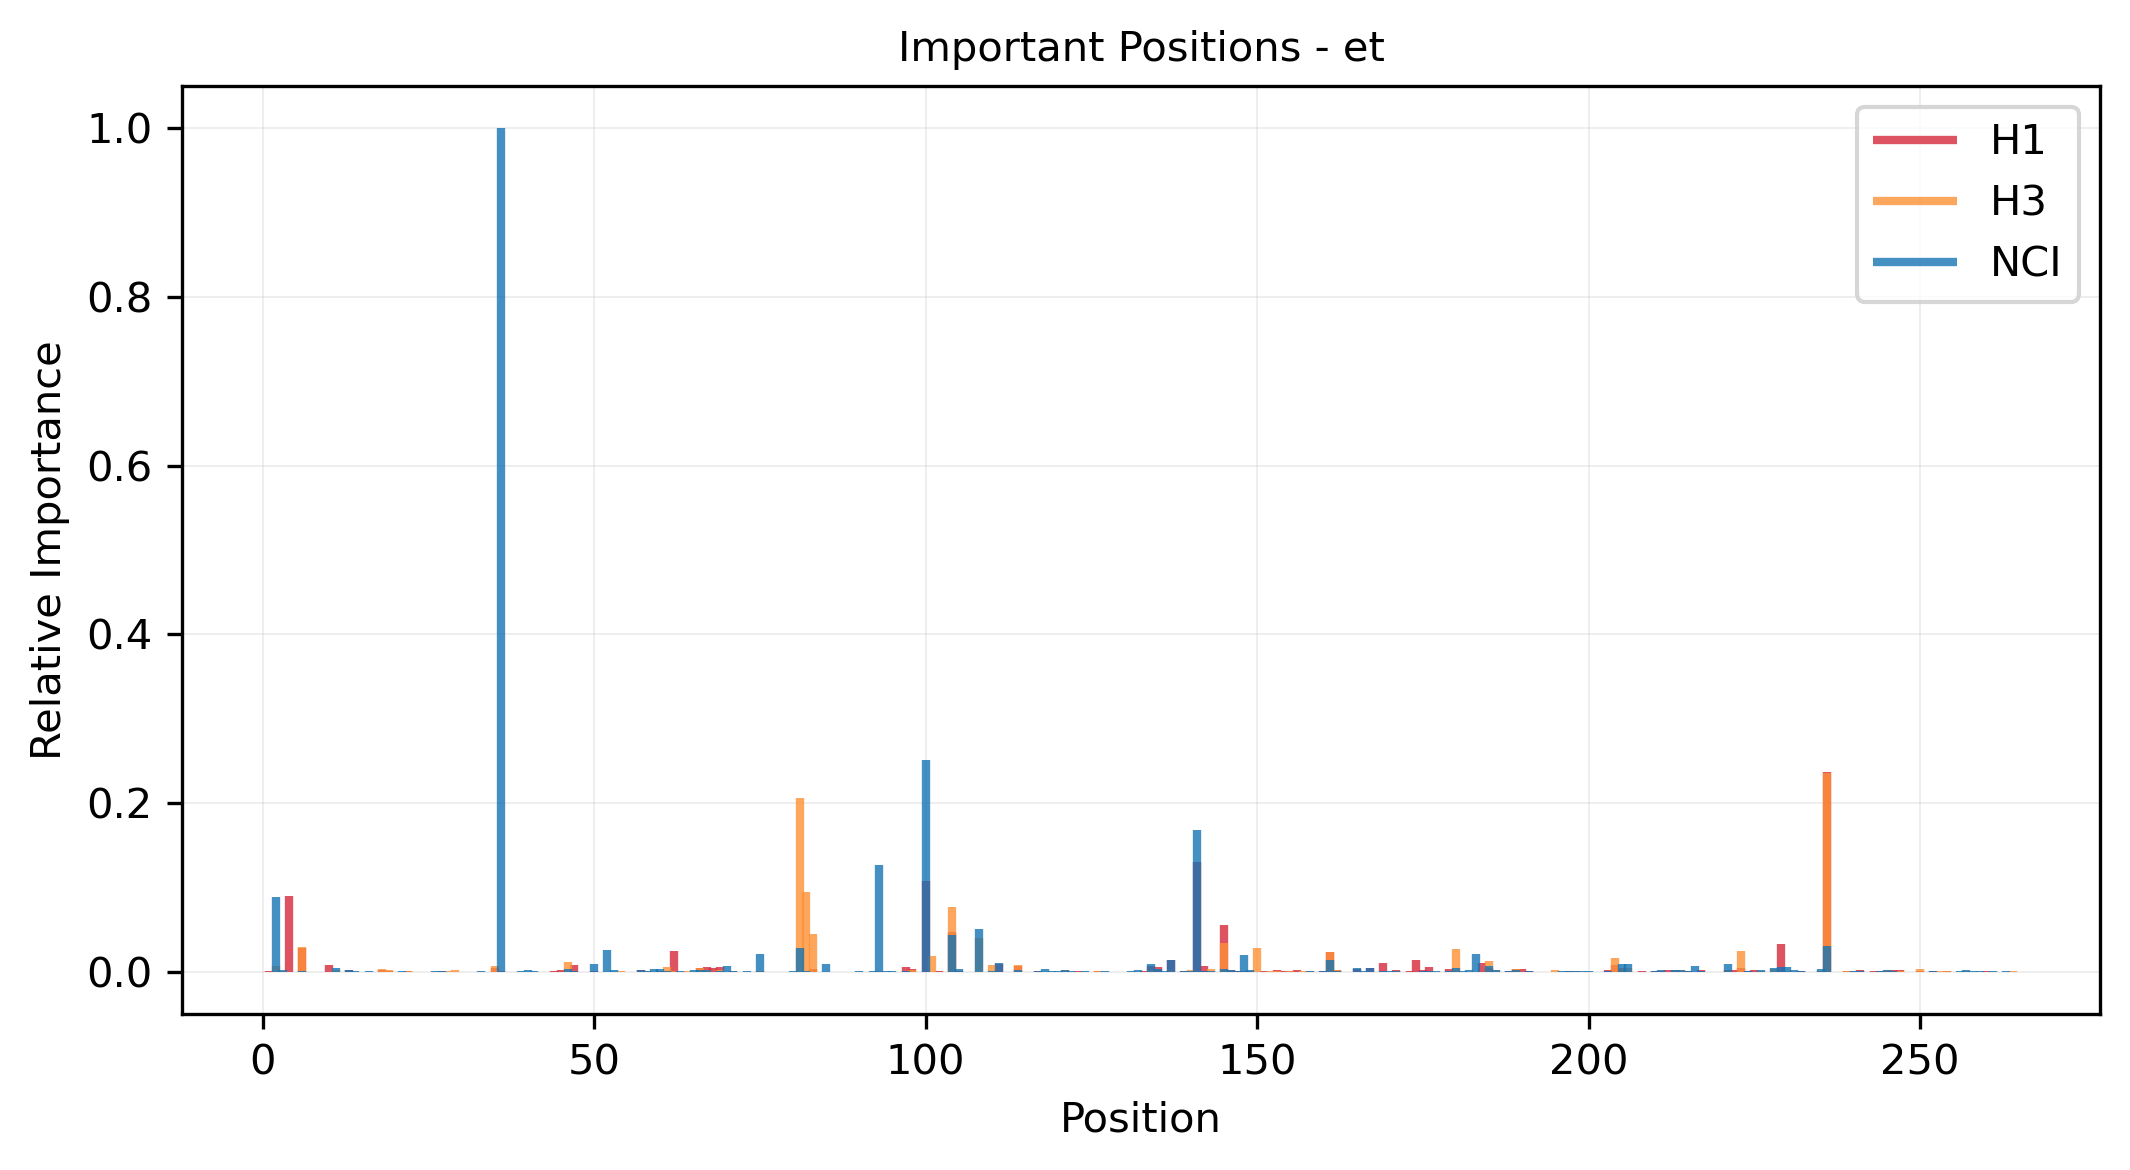

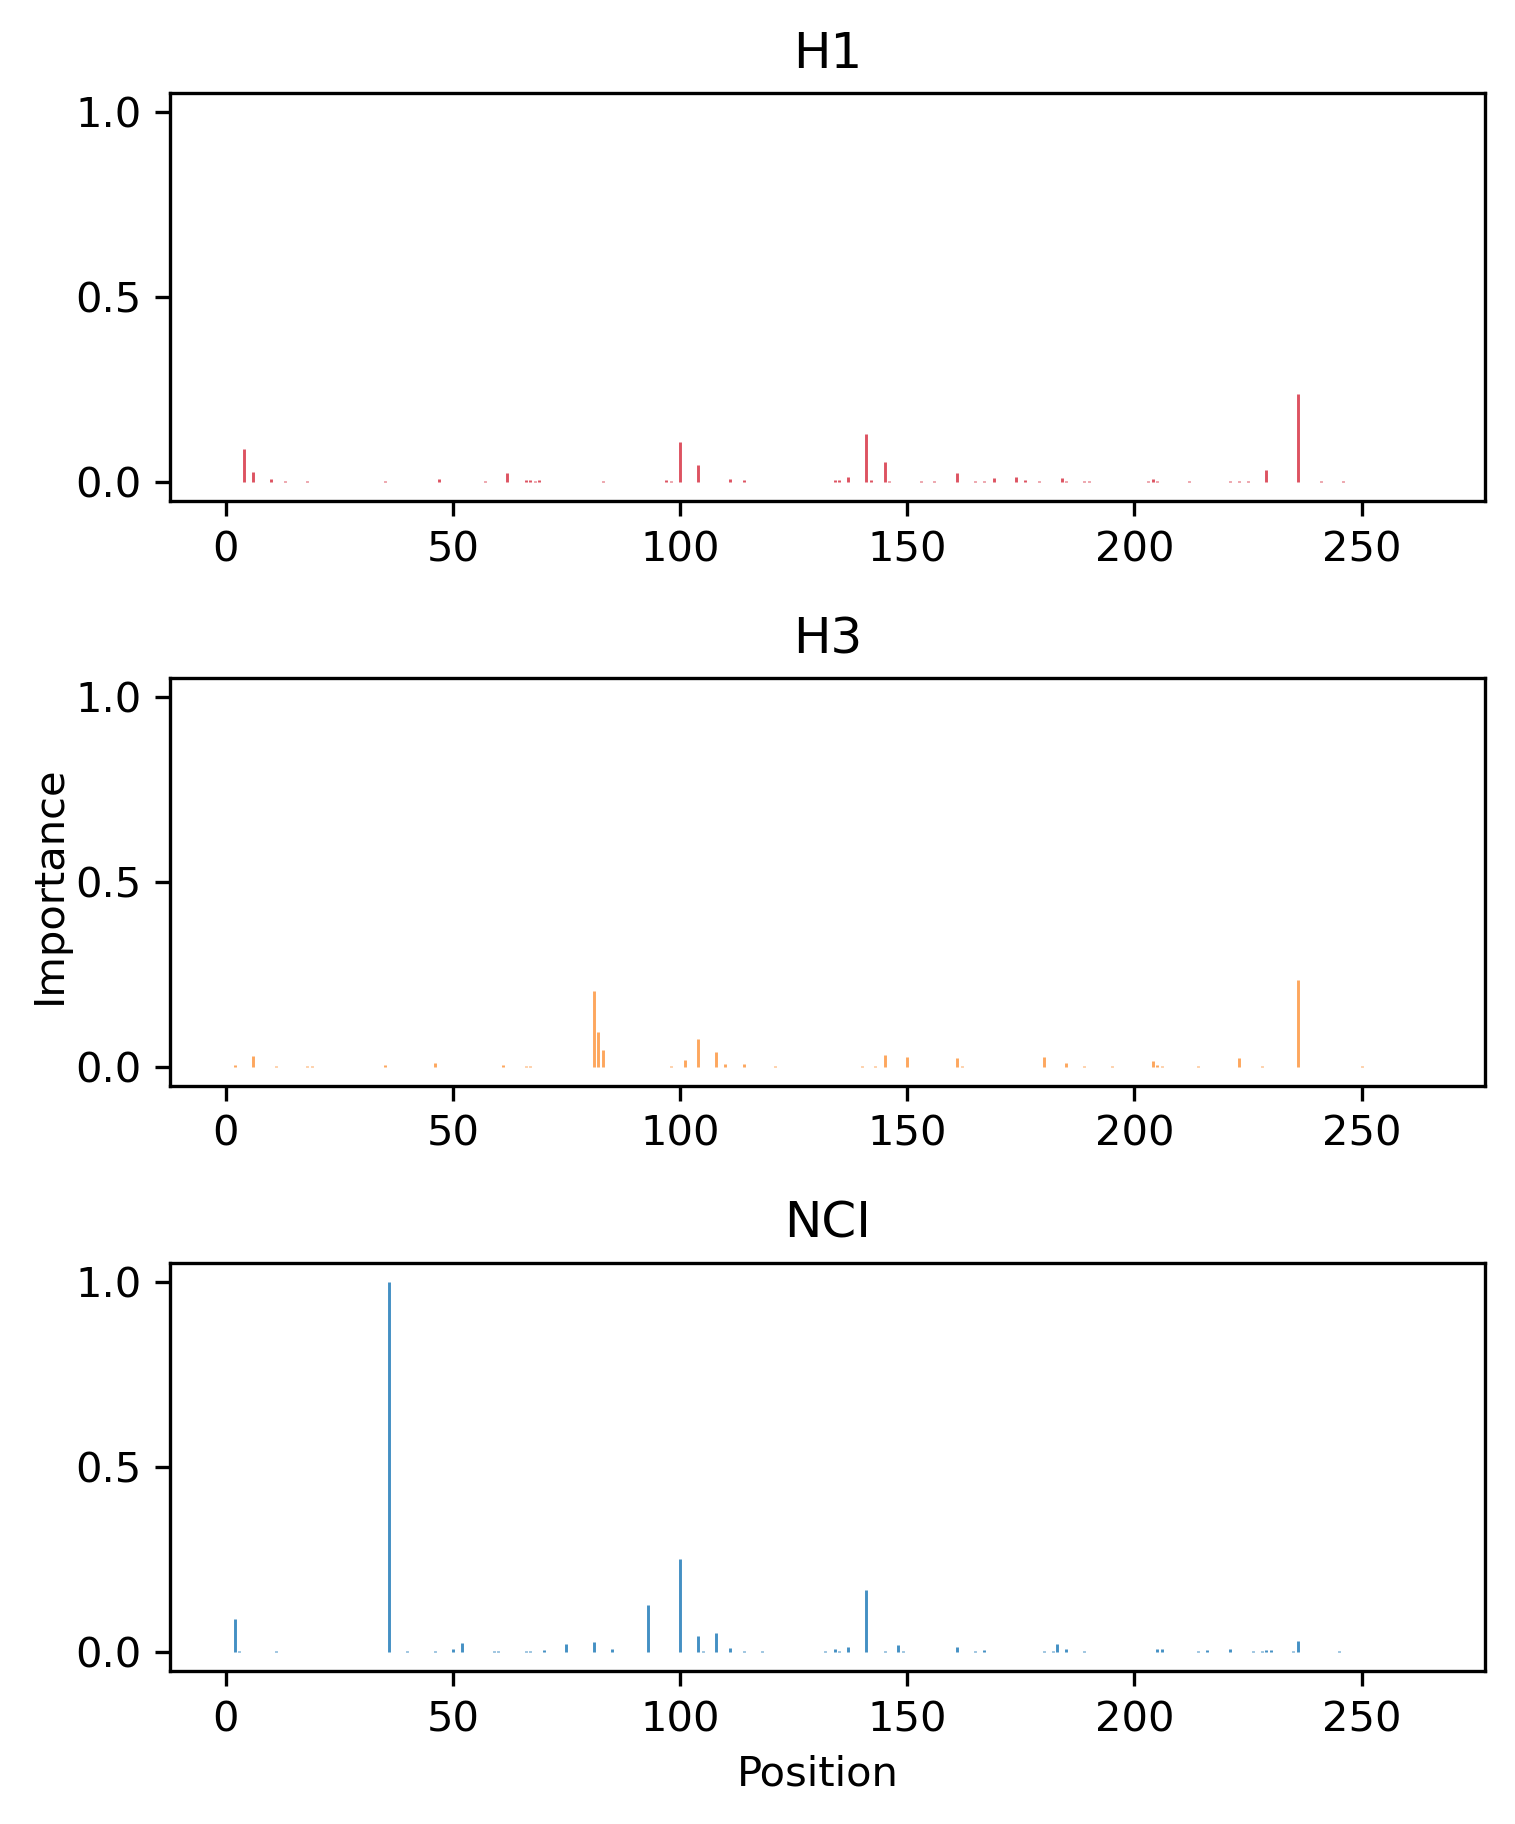

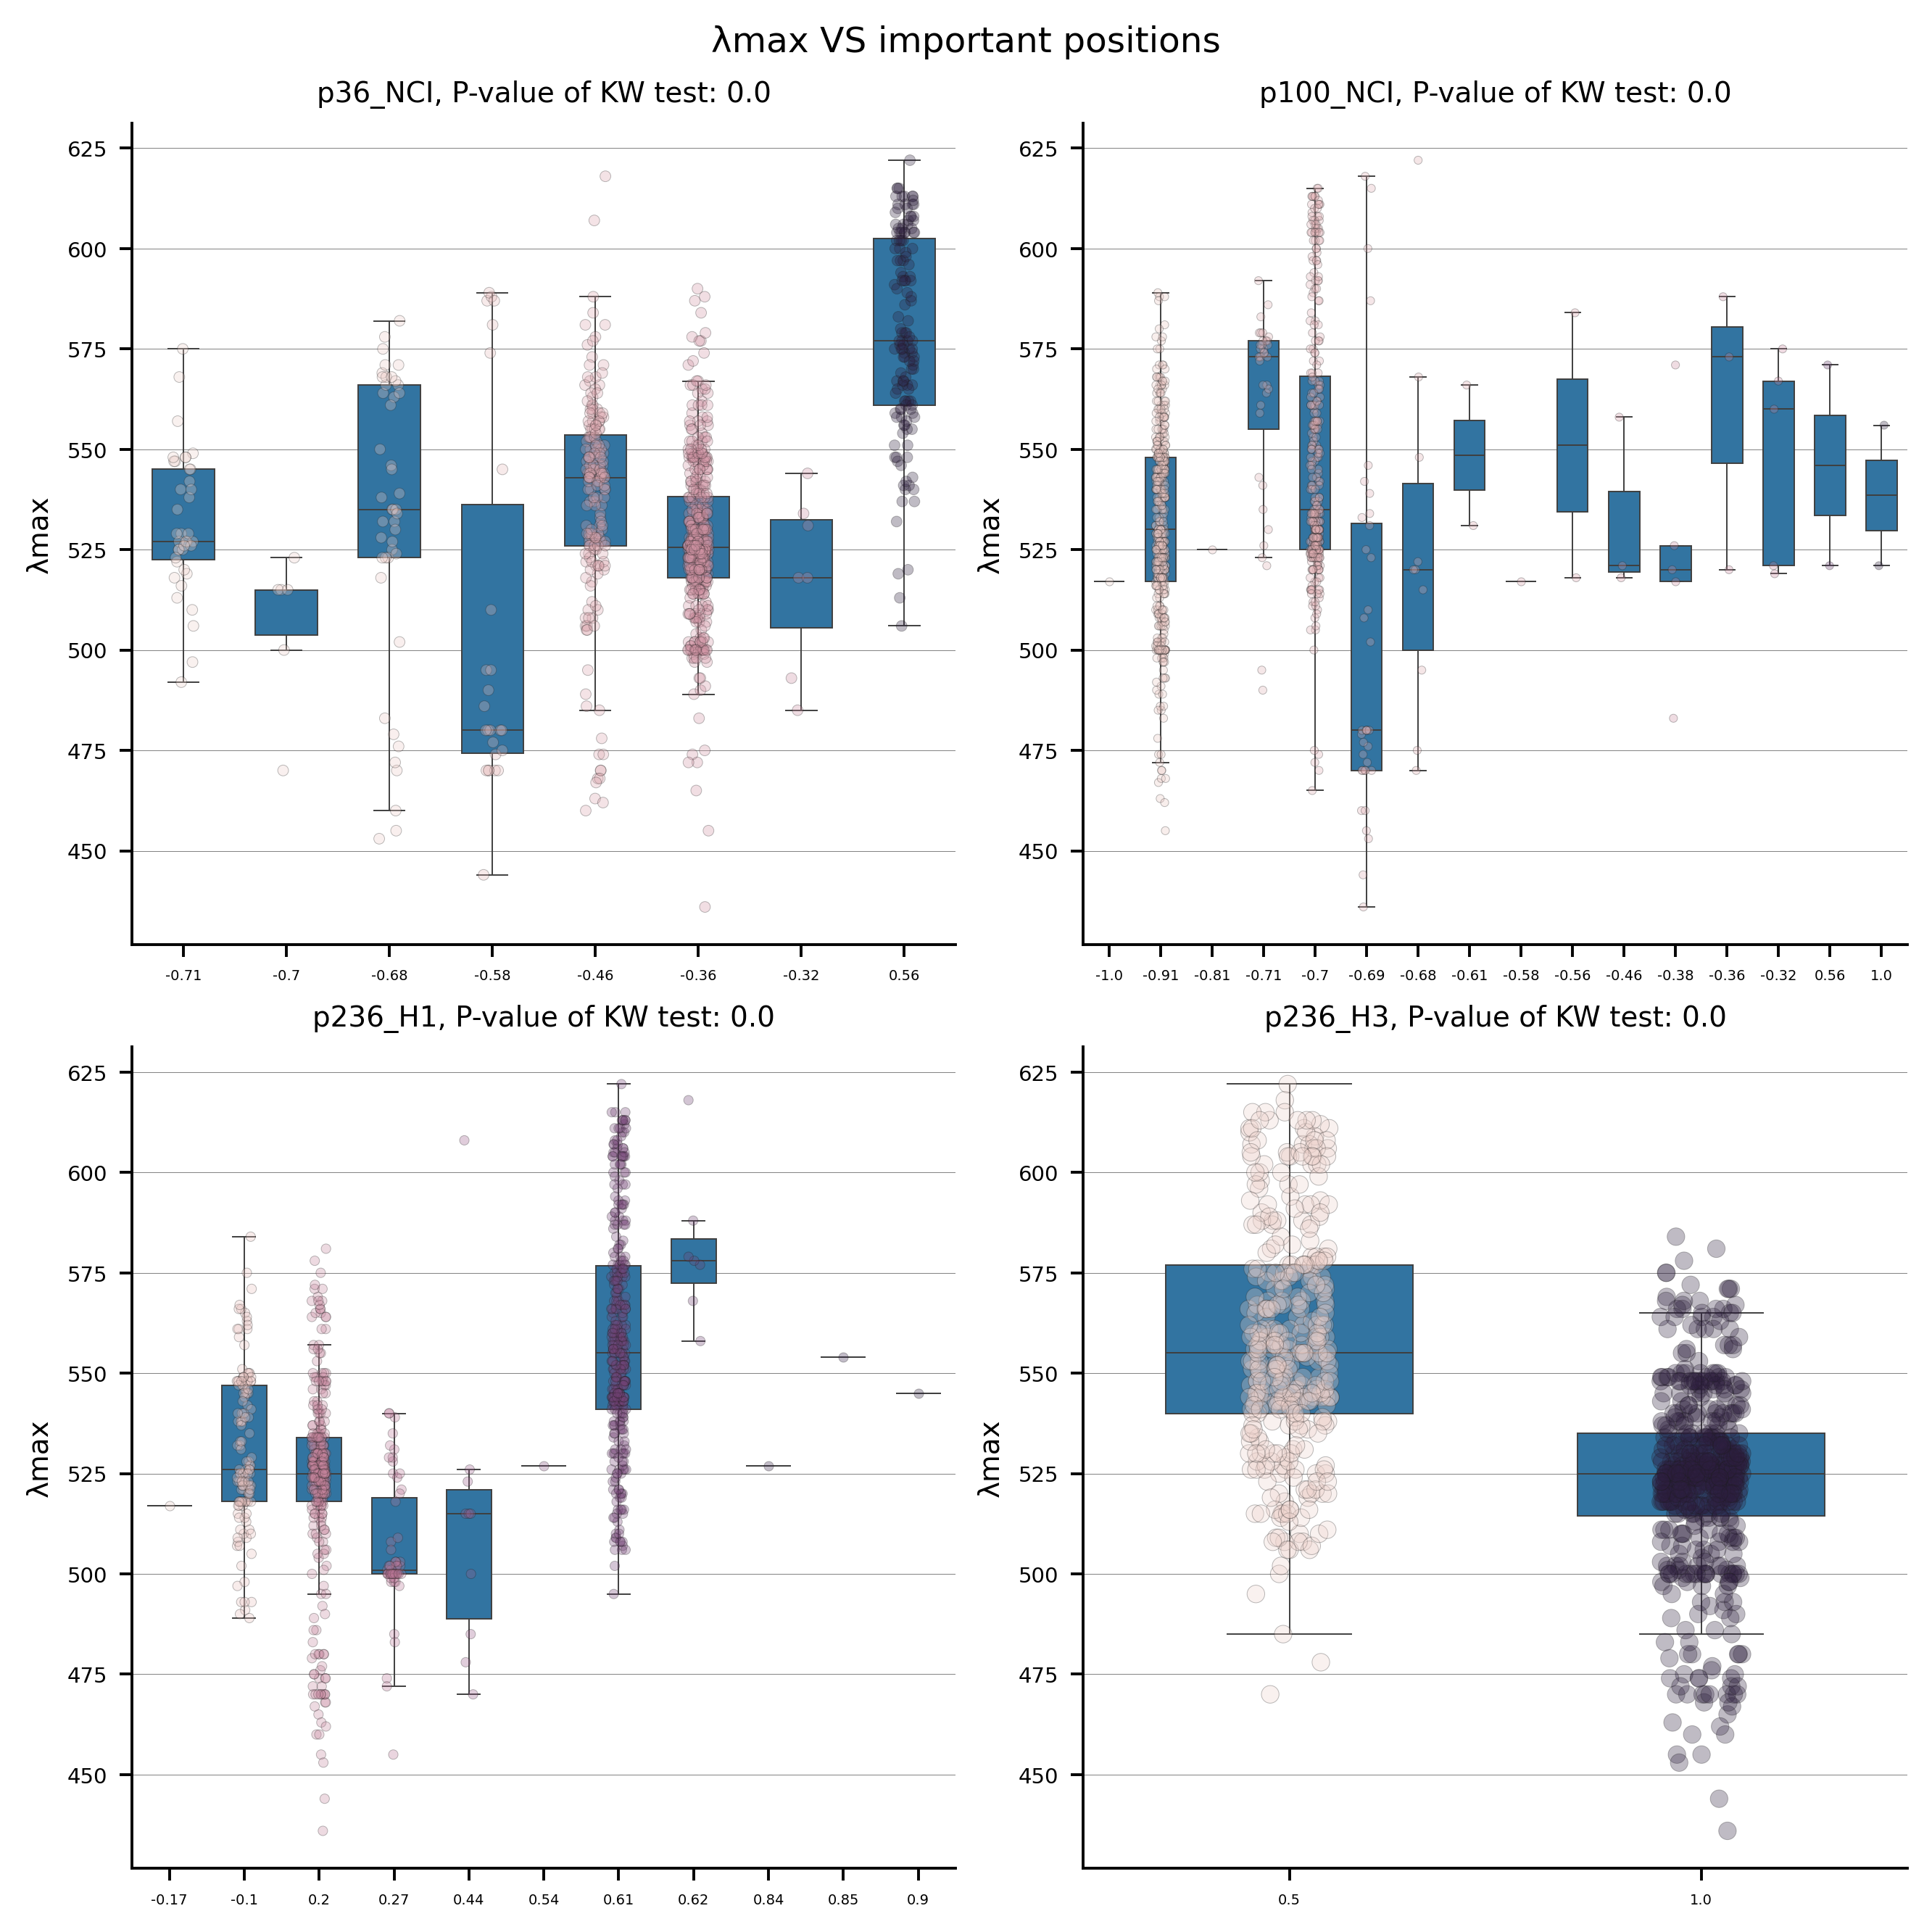

In [35]:
for model in top:
    tr = model.named_steps['prep']['aa_prop'].aa_encoded_seqs_
    model_name = model.steps[-1][0]
    
    dp_aa_prop_plot(importance=aaprop_importance_from_pipe(model),
            imp_col='standard_value',
            model_name = model_name, report_dir=report_dir, props_to_keep = props_to_keep)
    
    plot_imp_model(importance=aaprop_importance_from_pipe(model), 
               X_train=tr, y_train=y, model_name=model_name,
                   meta_var='λmax', model_type=ana_type, report_dir=report_dir)

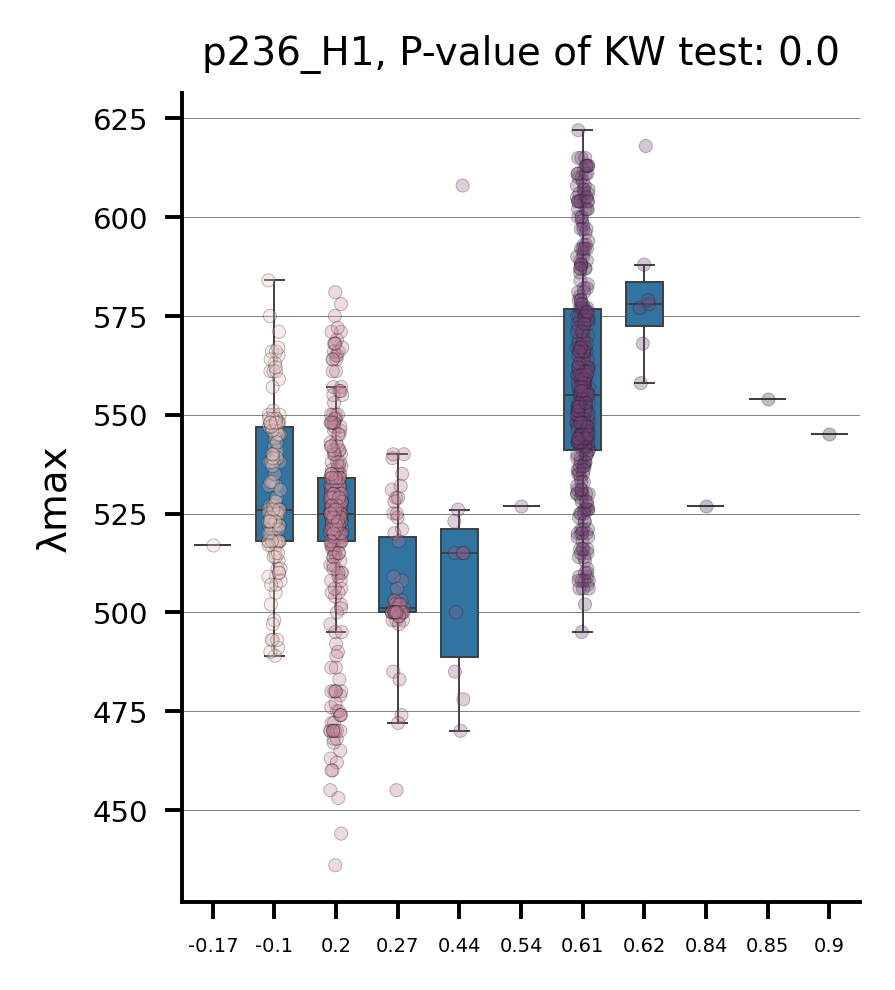

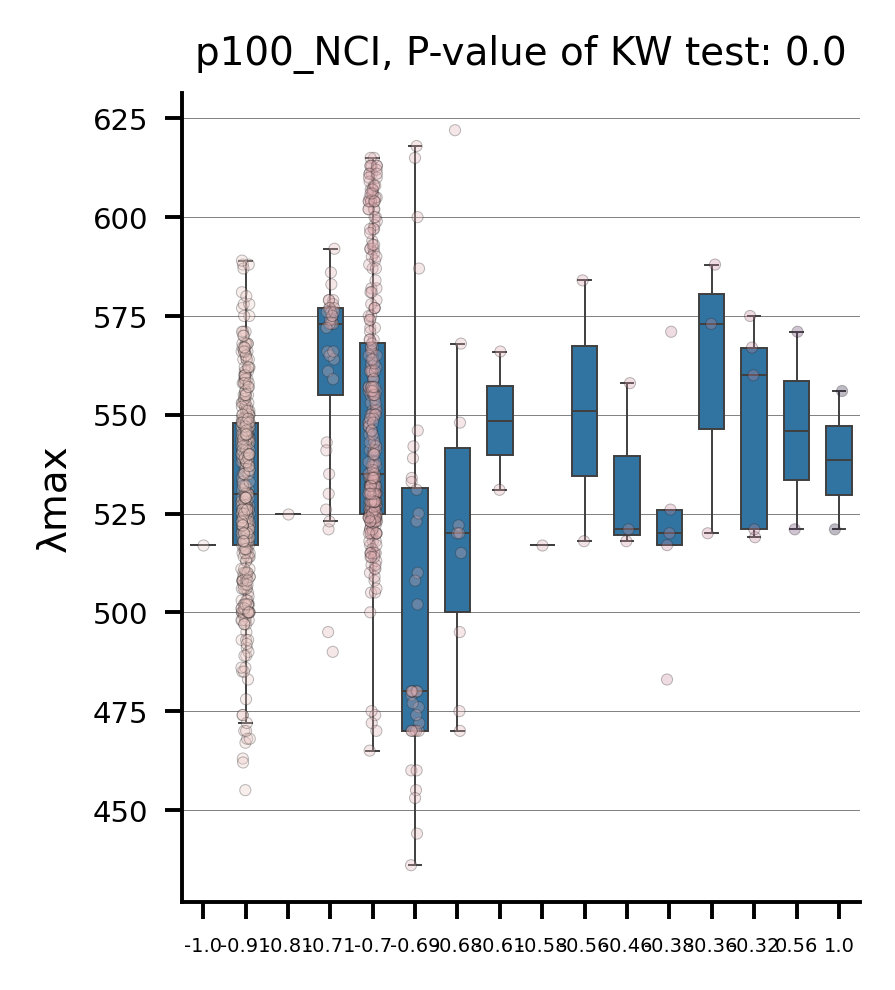

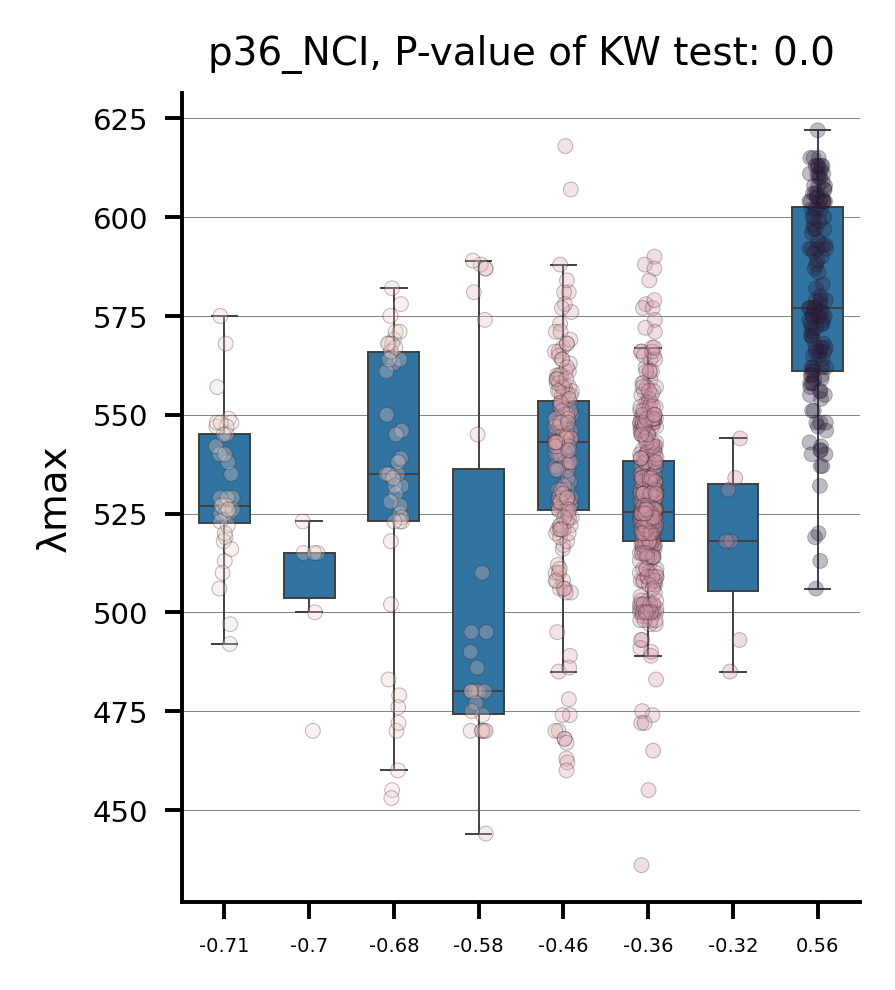

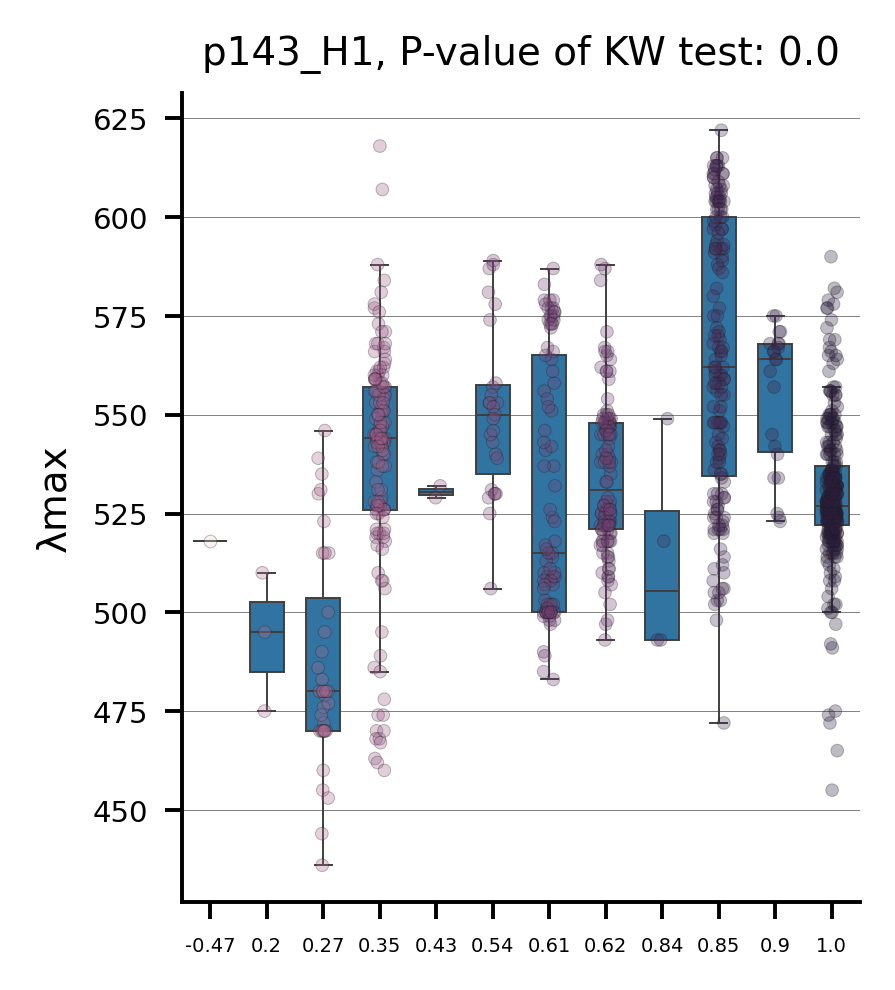

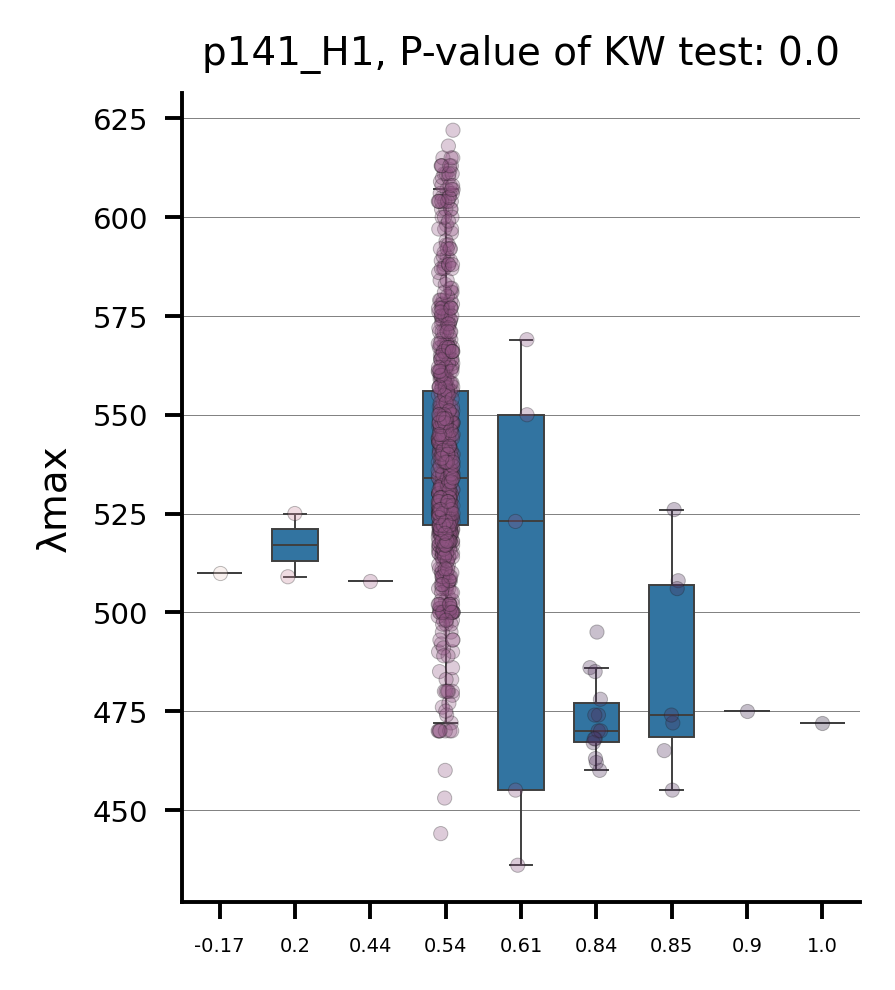

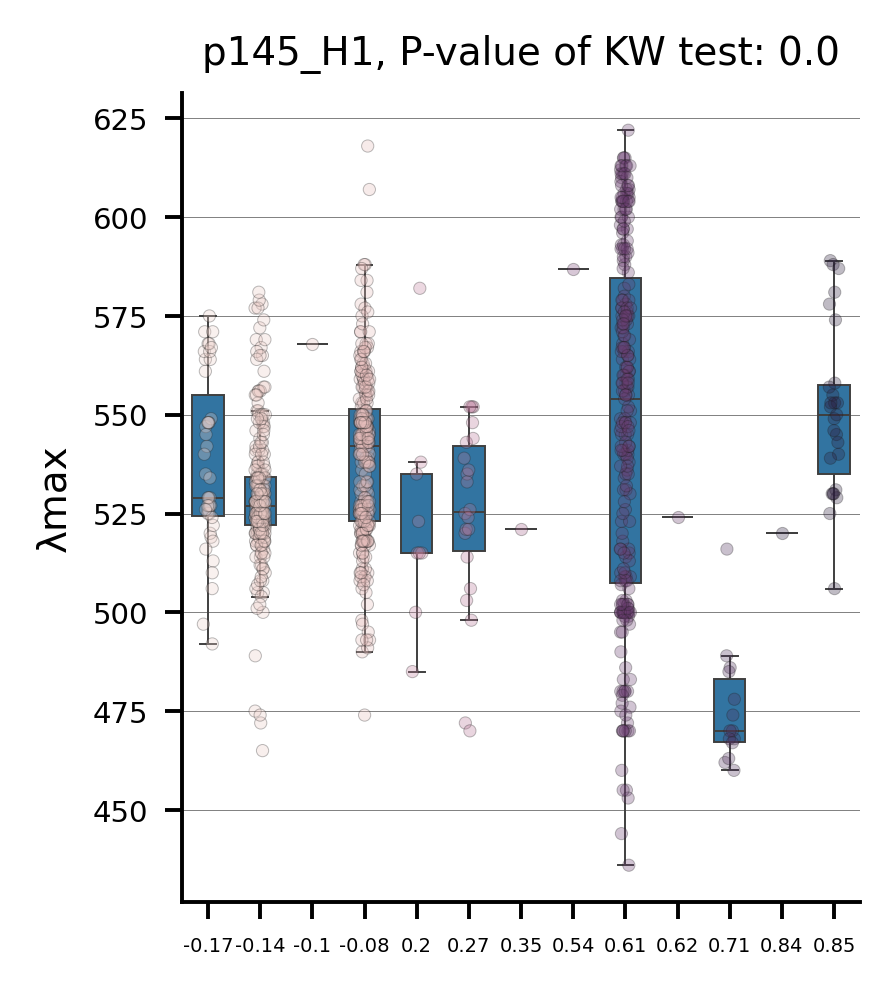

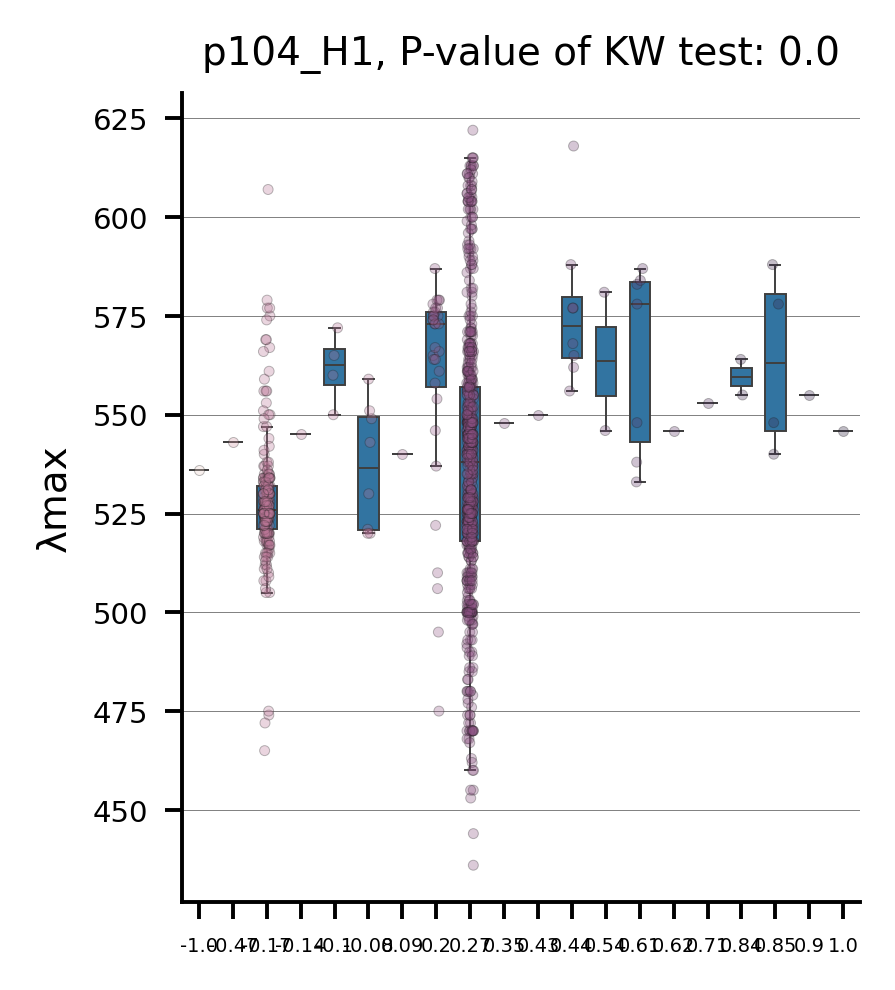

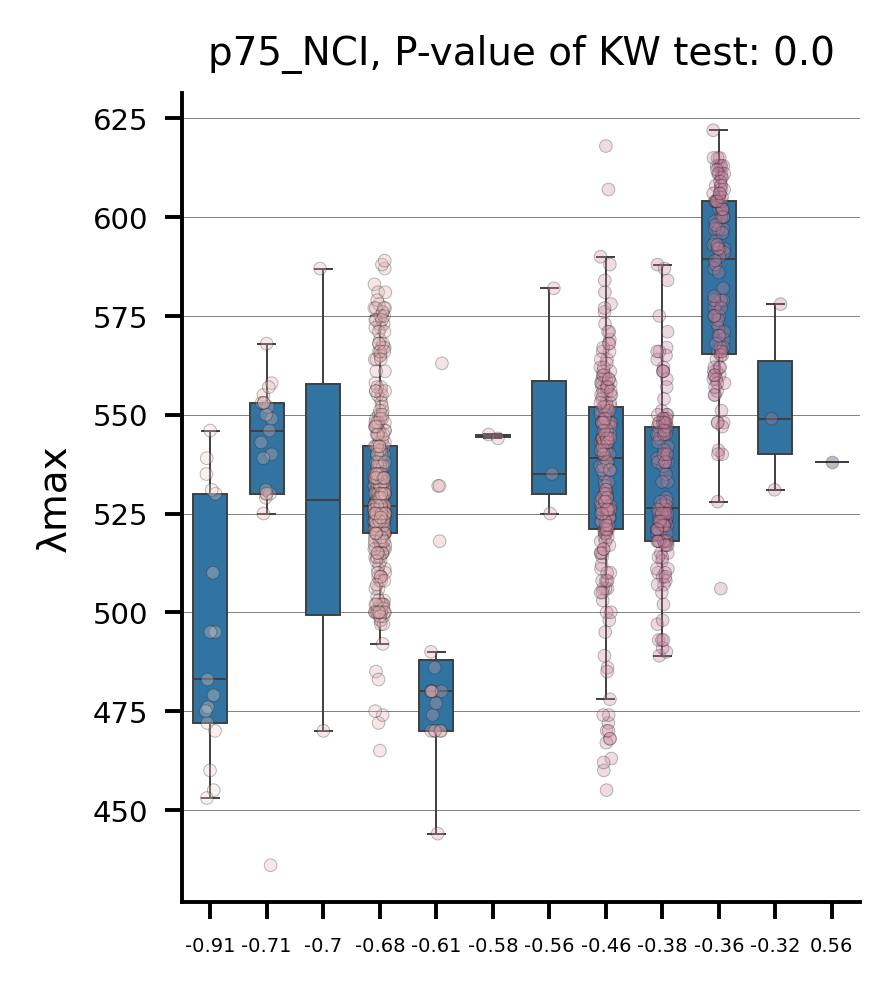

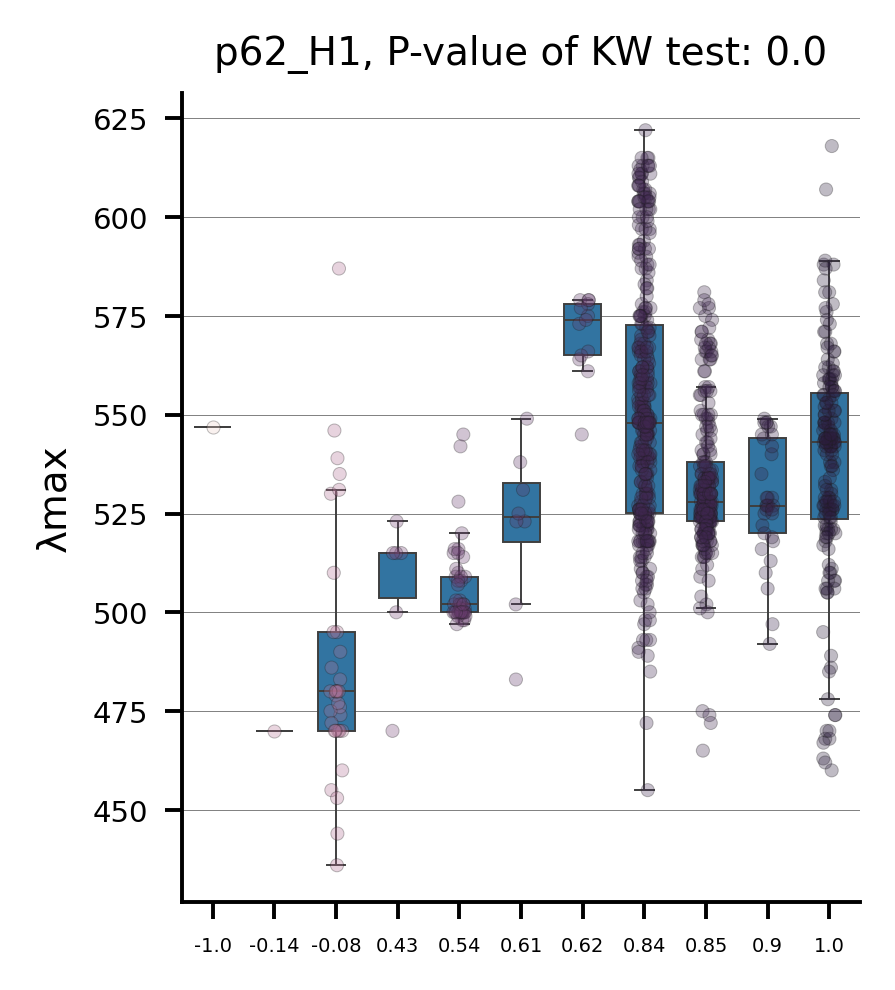

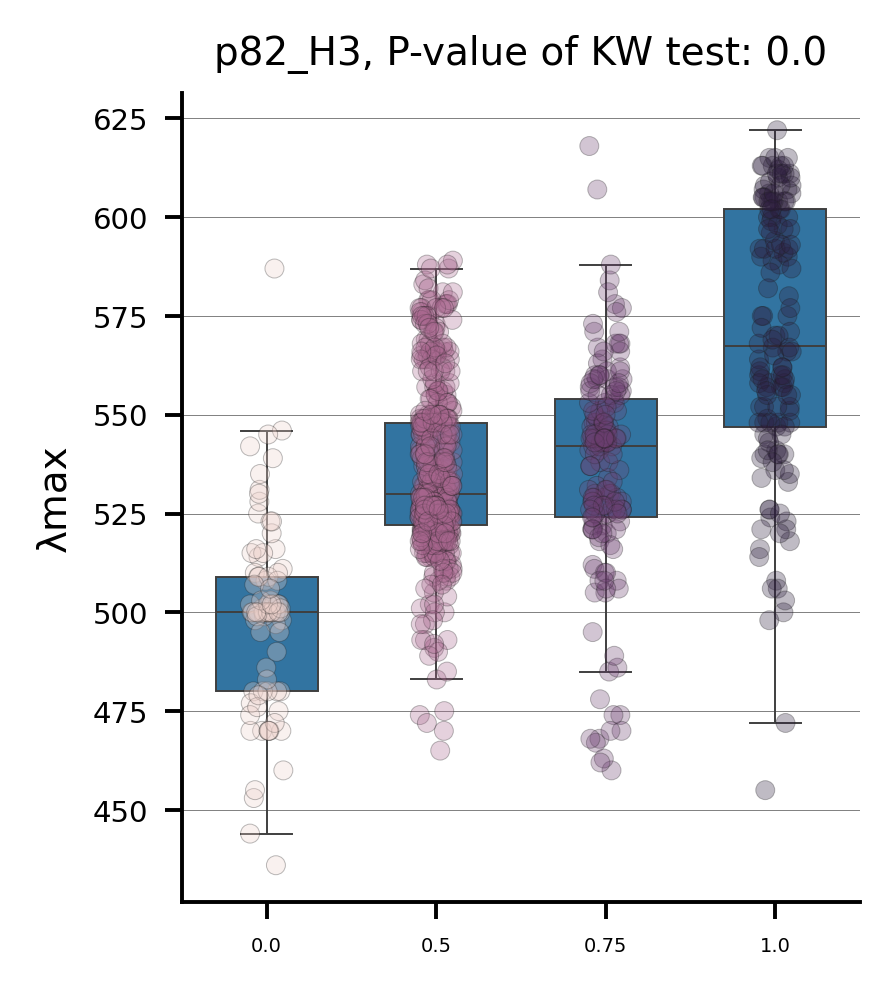

In [37]:
pl = plot_imp_all(final_models=top,
                  X_train=tr, y_train=y,
                  model_type = ana_type,
                  report_dir=report_dir, max_plots=10,
                  figsize=(2.5, 3), meta_var='λmax')

In [ ]:
from deepBreaks.utils import load_obj
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [ ]:
top_per_mod = report_dir + '/' + mtml[0] + '.pkl'
load_top_mod = load_obj(top_per_mod)

In [ ]:
print(f'Here is a list of your top performing models to test...\n{mtml}')

# <font color=red>STEP 4: Translate Candidate STSs</font> 
## This section is used to translate candidate STSs to the bovine or squid equivalent.
### The bovine and squid sequence dataframes that were saved earlier and are called again here


In [ ]:
import pandas as pd
import os

In [ ]:
#STEP 4: Translate Candidate STSs 
#translate candidate STSs to the bovine or squid equivalent 
    #bovine and squid sequence dataframes were saved earlier and are called again here
m = 0
tm = ''
k=0
gaps=0
#import importance_report.csv from report_dir
true_pos = []
aa = []
tmd = []
df = pd.read_csv(f'{report_dir}\importance_report.csv')
indx_list = df.feature.tolist()
pos_list = []
for x in indx_list:
    pos = x.split('p')[0]
    pos = x.split('_')[0]
    
    pos_list.append(int(pos))
#print(pos_list)
df['feat_pos'] = pos_list
df = df.sort_values('feat_pos', ascending=True).reset_index(drop = True)

#take the list of important sites and translate them to the bovine standard equivalent, 
#we do this by taking the site number and subtracting the number of '-' between the start of the sequence and the desired site. 
for rows in reference_seq.values:  
    rows = str(rows)
    #print(rows)
    if rows == 'nan' or rows == 'NaN' or rows=='-' or rows==None:
    #We want to write the 'true_pos', 'aa', and 'TMD' to the 'importance_report' csv file
        gaps += 1
        k += 1
        true_pos.append('NA')
        aa.append('-')
        tmd.append('NA')
    else:
        #print("The number of gaps is " + str(gaps))
        k+=1
        trans_site = k - gaps
        if ref_seq_name == 'bovine':
            if trans_site in range(3,37):
                tm = 'N-Termina'
            elif trans_site in range(37,62):
                tm = '1'
            elif trans_site in range(74,96):
                tm = '2'
            elif trans_site in range(111,133):
                tm = '3'
            elif trans_site in range(153,174):
                tm = '4'
            elif trans_site in range(203,225):
                tm = '5'
            elif trans_site in range(253,275):
                tm = '6'
            elif trans_site in range(287,309):
                tm = '7'
            else:
                tm = 'CT/EC'
        else:
            if trans_site in range(3,34):
                tm = 'N-Termina'
            elif trans_site in range(34,59):
                tm = '1'
            elif trans_site in range(71,97):
                tm = '2'
            elif trans_site in range(110,132):
                tm = '3'
            elif trans_site in range(152,173):
                tm = '4'
            elif trans_site in range(200,225):
                tm = '5'
            elif trans_site in range(262,284):
                tm = '6'
            elif trans_site in range(294,315):
                tm = '7'
            else:
                tm = 'CT/EC'                
        
        true_pos.append(str(trans_site))
        aa.append(rows)
        tmd.append(tm)
#true_pos.pop()
#aa.pop()
#tmd.pop()

x = 1
exp_true_pos = []
exp_tmd = []
exp_aa = []
for feat in df.feat_pos:
    entered = False
    while entered == False:
        if feat == x:
            exp_true_pos.append(true_pos[x-1])
            exp_tmd.append(tmd[x-1])
            exp_aa.append(aa[x-1])
            entered = True
        else:
            x+=1
            pass


df['true_position'] = exp_true_pos
df['TMD'] = exp_tmd
df['amino_acid'] = exp_aa
df.drop(columns='feat_pos')
df.to_csv(path_or_buf= os.path.join(report_dir,r'importance_report.csv'),index = 'Feature',mode="w")
#df.head()

# <font color=red>STEP 5: Query the Model to Predict NEW Sequences</font> 
## Takes new sequences, inserts them into existing alignment to properly format for model query, then returns prediction of the λmax value for each sequence...

In [ ]:
import os
import subprocess
from deepBreaks.utils import load_obj
from deepBreaks.preprocessing import read_data
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from vpod_scripts.prediction_functions_db_aa_prop_encoded import process_sequences_from_file

This is a version of the prediction method which can be used DIRECTLY after model training... 

In [ ]:
#path to the mafft.bat file - change to your own directory!
mafft_exe = 'C:/Users/safra/mafft-win/mafft.bat'
#path to sequences we want to add to an existing alignment in FASTA format
input_file = './supp_test_data/msp_erg_raw.txt'
#name for desired output file
output_file = f'{report_dir}/opsin_predictions.tsv'
#path to target/selected model
selected_model = report_dir + '/' + mtml[1] + '.pkl'
#function for querying model - this will take care of creating an output file for you.
predictions_df = process_sequences_from_file(mafft_exe,input_file,output_file,selected_model,seqFileName, gap_threshold=gap_threshold)


In [ ]:
msp_meta_file = './supp_test_data/msp_erg_meta.tsv'
msp_meta = read_data(msp_meta_file, seq_type = None, is_main=False)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


# Create scatter plot
plt.scatter(msp_meta['Lambda_Max'], predictions_df['Predictions'])

# Add labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Model Predictions vs True Values')

# Display plot
plt.show()

# Calculate R-squared
r2 = r2_score(msp_meta['Lambda_Max'], predictions_df['Predictions'])

# Print R-squared
print(f"R-squared: {r2:.3f}")